**Automated Essay Scoring: A Neural Network Ensemble Approach**

Kevin Anthony S. Sison and Van Arloe M. Yu

Master of Science in Data Science, ASITE, Asian Institute of Management


# Abstract


Automated essay scoring is cost-effective and a rapid way of delivering student feedback. It’s implementation would provide a standard scoring mechanism for global examinations and reduce examiner bias. The dataset used in this study was from the Automated Student Assessment Prize (ASAP) downloaded from Kaggle. Essays from this dataset were marked by two human raters and this study created a model that would predict the total score for each essay in the dataset. Quadratic Weighted Kappa (QWK) was used to measure the agreement between human and machine ratings. Feature engineering created 32 features (textual and non-textual). Non-textual features include count and collocation of n-grams, while textual features cover document embeddings. Different machine learning models were implemented to predict the total essay scores. The best performing models are the Gradient Boosting Regressor (QWK = 0.9848 training time = 6 min) and the Fully Connected Deep Network and LSTM ensemble (QWK = 0.9854 training time = 33 min). Further, the GBR via SHAP revealed that the top 3 most important features are the essay set, number of unique words, and the number of sentences. Improvements can be done on the model by using better document embedding techniques, training separate models for each essay set, extracting other features such as Latent Semantic Analysis (LSA) and sentiment scores. 

# Introduction

Automated Essay Scoring (AES) allows grading of student essays without human interference. It takes in an essay for a given prompt and outputs a numeric score reflecting its quality, based on its content, grammar, and organization​. This would provide a standard scoring mechanism for global examinations like GRE, GMAT, TOEFL, and IELTS. An automated essay scoring system would reduce examiner bias when checking student essays and as a result it would liberate more time for teachers and so they can devote more time in improving their lessons and delivery. This would also allow teachers to give quick feedback to work on areas of weakness. 
  
Since February 1999, the Educational Testing Service has utilized E-rater, a system for automated essay scoring particularly used for the Graduate Management Admission Test Analytical Writing Assessment (GMAT® AWA). The system has two components, a scoring application and Critique, composed of programs that can evaluate and identify grammatical errors. This system was also trained with a sample of essays on the same topic that was rated as well by human readers. The new e-rater system was trained with a new feature set that includes errors in grammar, usage, mechanics, and style, organization and development, lexical complexity (ratio of number of word types to tokens, measure of vocabulary level based on Breland’s standardized frequency index value, and average word length), prompt-specific vocabulary usage (score point value and cosine correlation), and essay length (Attali and Burstein, 2005). 

One potential problem of AI based essay graders is that the algorithm may not be able to distinguish between quality and drivel. Such inabilities were tested and described in an article published in Forbes magazine. For example switching the words “the” in the essay to “chimpanzee” gave a score of 6 out of 6. These automated scoring programs cannot distinguish between a well-written essay and something that is meaningless. A research affiliate from MIT developed a system that creates essays with no sense but captures top scores from AES to reveal AES’ weaknesses. This is taken advantage of by people as they try to game the system by putting all the things an AES focuses on and putting it in their essays. 


# Import Libraries

In [49]:
# importing required packages

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score

from nltk import word_tokenize,sent_tokenize
import missingno as msno

import nltk
import numpy as np
import spacy
import pandas as pd
import json
import string
import math
from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
stop_words = nltk.corpus.stopwords.words('english')
from textblob import TextBlob
from nltk.collocations import *

# nltk.download('all')
from tqdm import tqdm_notebook as tqdm




In [50]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
import matplotlib

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
    
%matplotlib inline

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, Dropout


from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate


2.0.0


In [2]:
%%capture
tqdm().pandas()

# Loading Dataset

Data Description

In 2012, the William and Flora Hewlett Foundation sponsored the Automated Student Assessment Prize (ASAP) competition in Kaggle. The competition was created to develop effective automated grading of student-written essays (The Hewlett Foundation: Automated Essay Scoring, 2012). The task of automated essay scoring has an input of the student essay written and the essay set identifier and an output of a predicted numeric score reflecting its quality, based on its content, grammar, and organization (Taghipour et al., 2016).

As seen in above, The dataset contains 8 essay sets, with each set corresponding to a different prompt or topic.  It contains 12,976 student-written essays. Each essay was marked by two human raters. The sum of the two scores given by rater 1 and rater 2 makes up the total score. The task is to predict the total score given for each essay in the dataset (The Hewlett Foundation: Automated Essay Scoring, 2012).

Open the dataset

In [3]:
# getting data in a pandas dataframe
df = pd.read_excel('training_set_rel3.xlsx', encoding = 'latin-1')

Check the nulls in the dataset. White cells are null

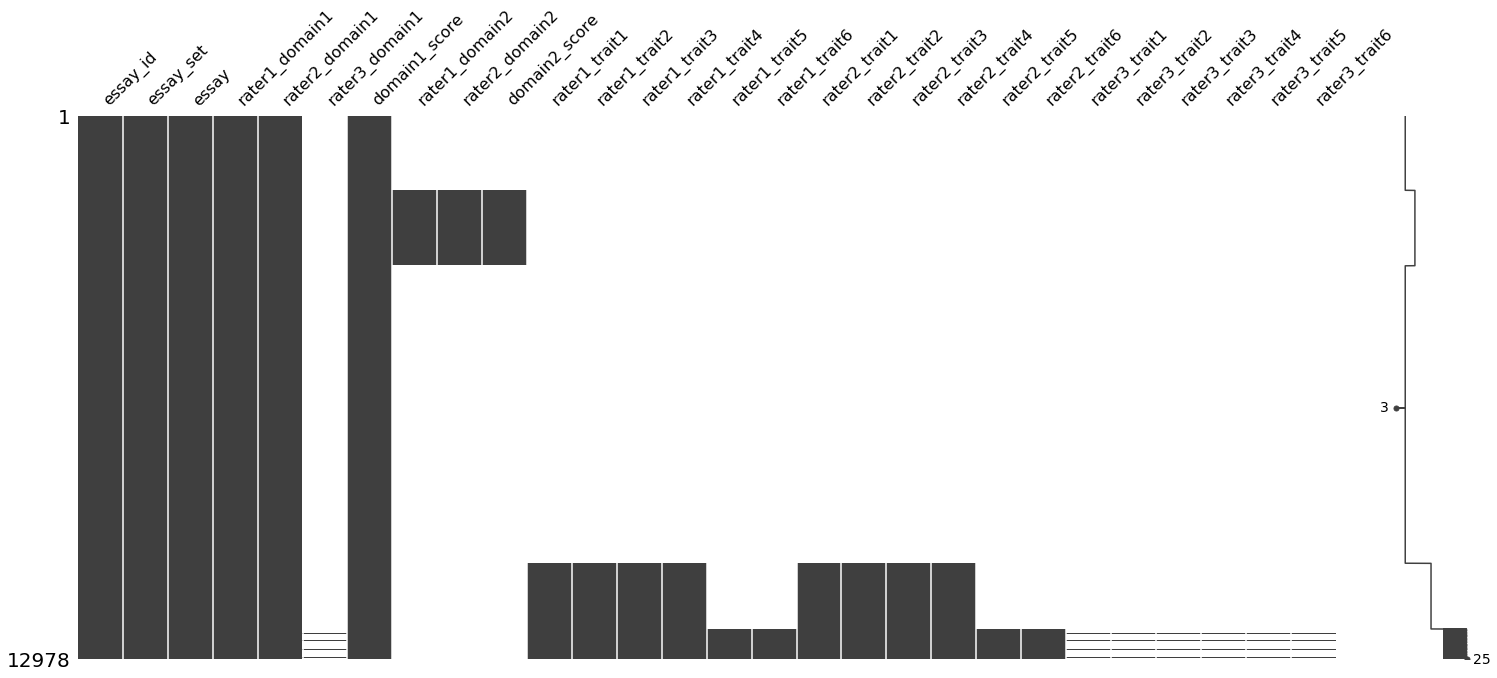

In [4]:
msno.matrix(df) 


We see that there are a lot of nulls in other columns. Let's just use the columns with complete data. Other references did the same.

In [5]:
df = df.iloc[:,1:7].drop(['rater3_domain1'],axis=1).dropna()


In [6]:
df = df.reset_index(drop=True)

In [7]:
print(df.shape)
(df.head())

(12977, 5)


,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score
0,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0
4,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0


In [8]:
df.iloc[1000].values

array([1,
       "Dear Newspaper, People should play with their family and friends instead of staying on the computer all the time. People would be more fit, have closer bonds with their family, and get better grades in school. People will alway get fit faster if they excersise instead of staying on the computer. When the computer is unpluged, anyone has a chance to go out side and play. When people go outside to play with their friends, they excersise which causes you to lose weight. @NUM1 scientist believe that it is better to go outside and socialize than to sit on a computer and watch monontenious videos. People would be more active if they stay of the computer and went outside because it will keep you happy with your body, and healthy so you don't die of a terrible diseases. Their would be closer bonds with families if people stayed of the computer. Family would be closer together instead of spreading apart by computers. Your family is always their to comfort you when ever you hav

In [9]:
df.head()

,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score
0,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0
4,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0


# Exploratory Data Analysis

To get our baseline, let's get the quadratic weight kappa (QWK) of the two raters. This will be our gold standard.

In [10]:
cohen_kappa_score(df['rater1_domain1'], df['rater2_domain1'], weights='quadratic')


0.9692784576664696

Do we have a good represntation for each essay set?

Yes, we have enough for each essay set. although there is imbalance with set 8.

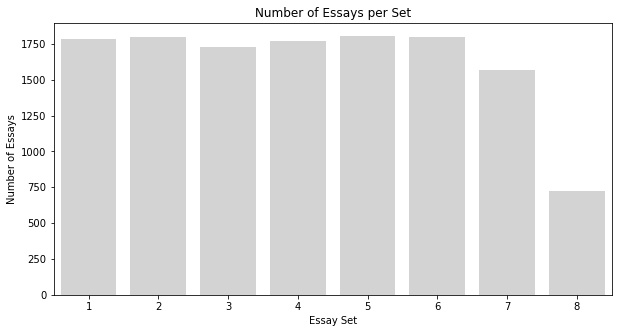

In [13]:
plt.figure(figsize=[10,5])
sns.barplot(x=(df['essay_set'].value_counts()).index, y=(df['essay_set'].value_counts()).values, color='lightgray')
plt.title('Number of Essays per Set')
plt.xlabel('Essay Set')
plt.ylabel('Number of Essays');

Let's see the distribution of scores the raters give out.

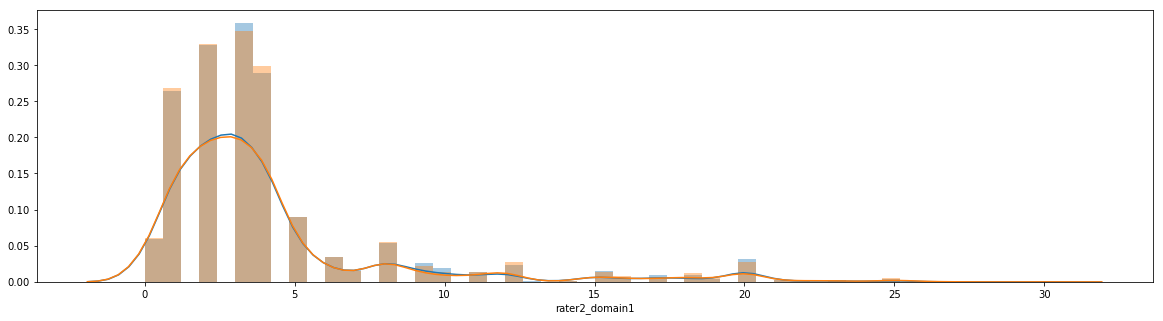

In [14]:
plt.figure(figsize=[20,5])
sns.distplot(df['rater1_domain1'])
sns.distplot(df['rater2_domain1'])

Let's see the distribution of scores the raters give out per essay set.

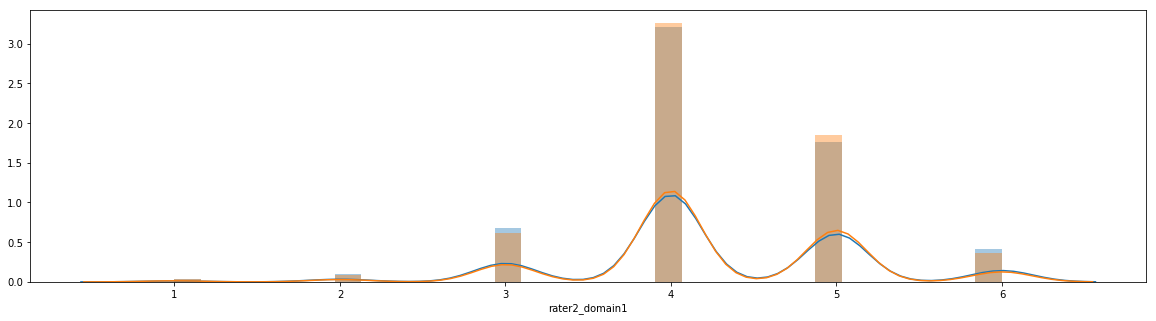

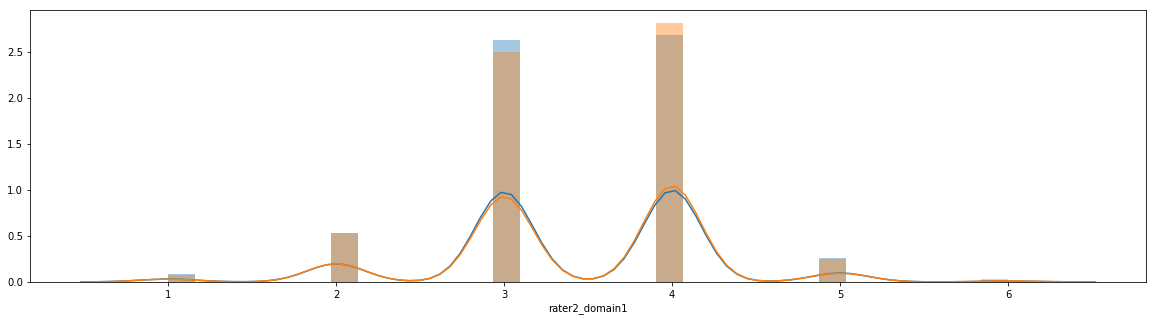

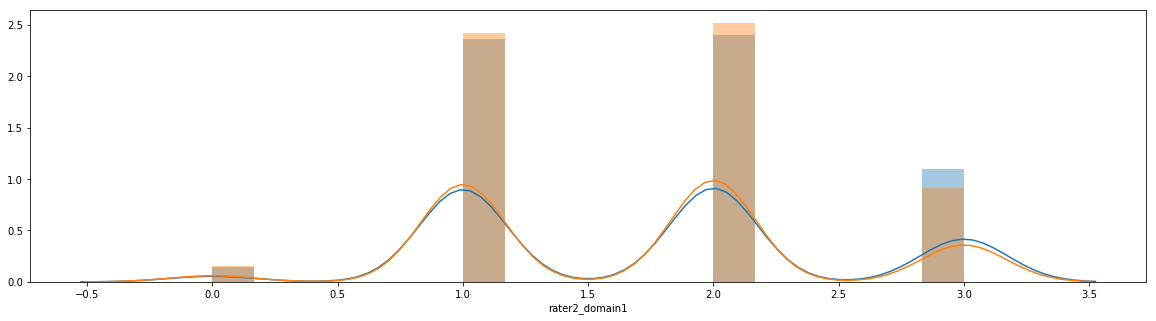

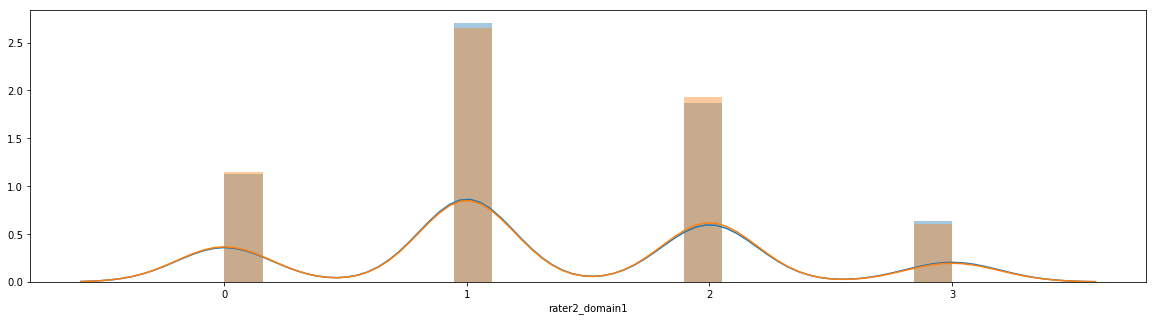

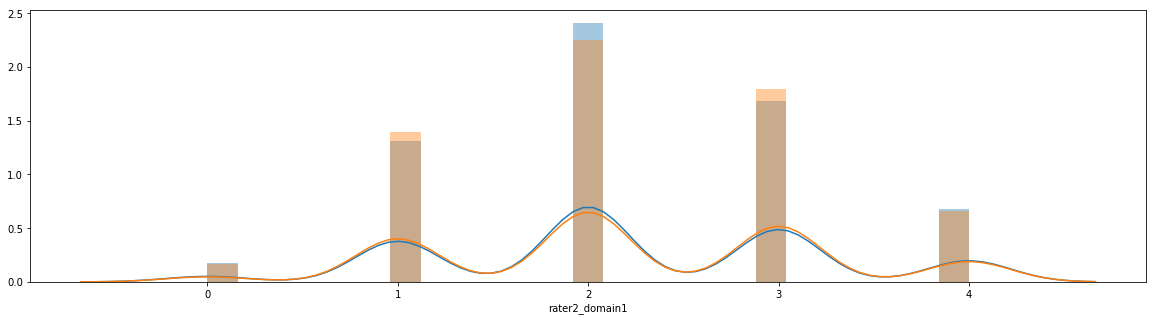

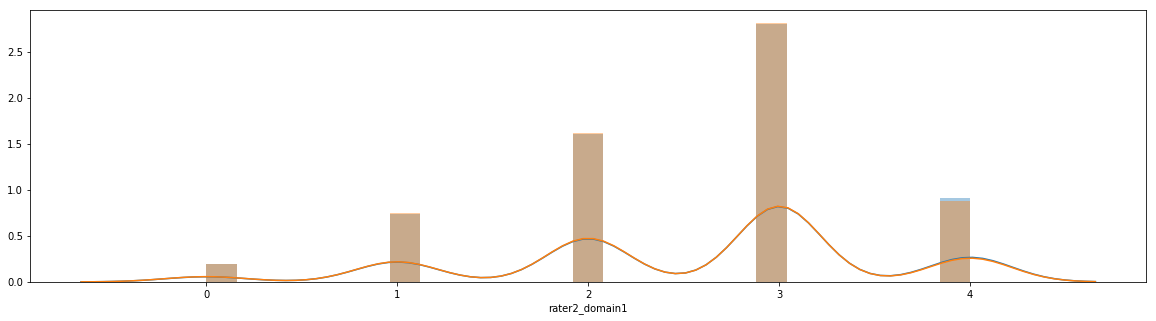

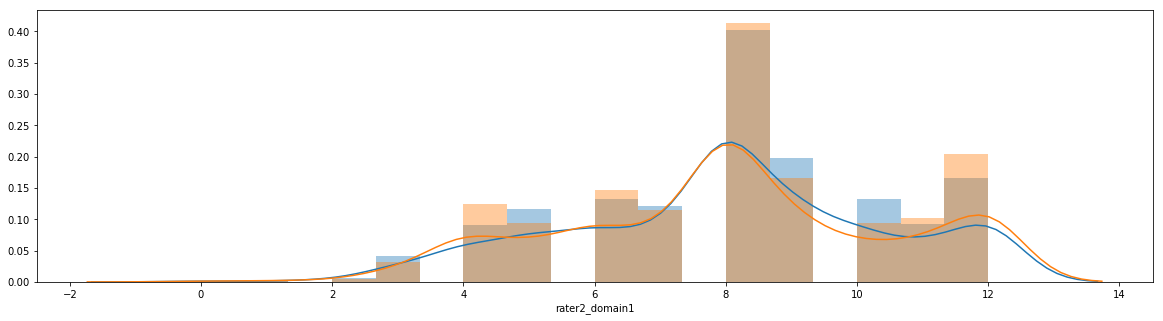

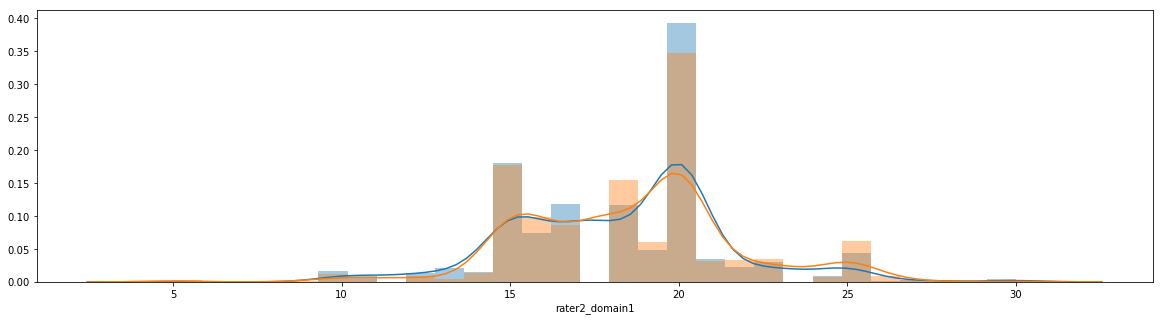

In [15]:
for i in range(1,9):
    plt.figure(figsize=[20,5])
    sns.distplot(df[df['essay_set']==i]['rater1_domain1'])
    sns.distplot(df[df['essay_set']==i]['rater2_domain1'])



Let's see the distribution of total scores. This is our target variable.

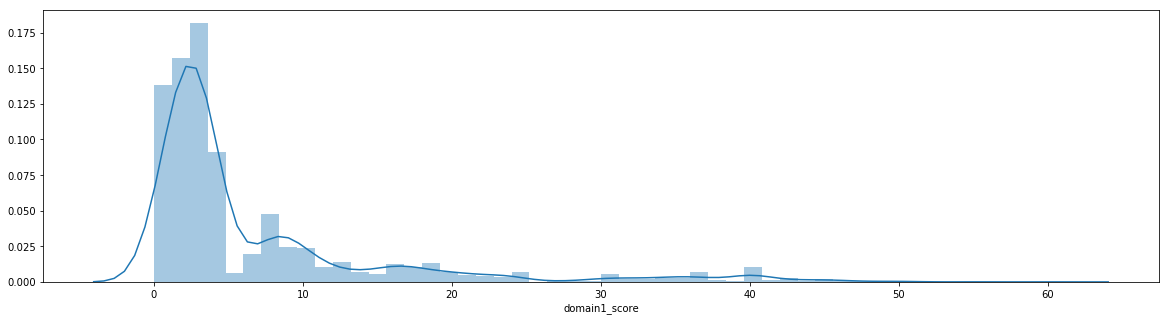

In [16]:

plt.figure(figsize=[20,5])
sns.distplot(df['domain1_score'])



Let's see the distribution of total scores per essay set. This is our target variable.

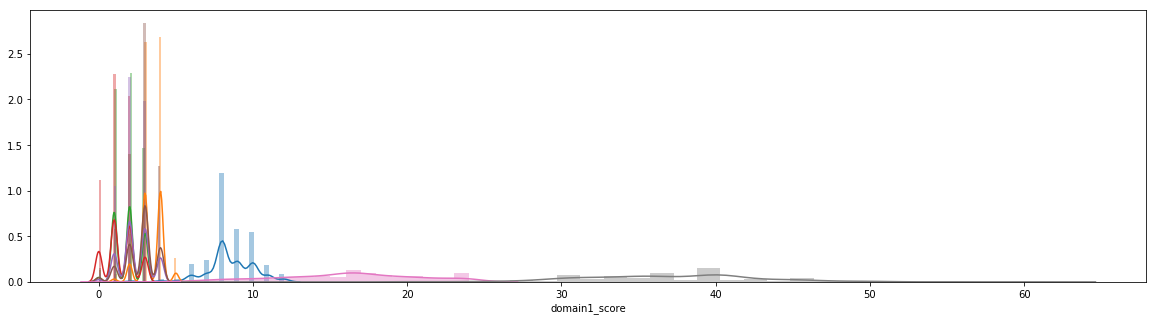

In [17]:
plt.figure(figsize=[20,5])

for i in range(1,9):
    sns.distplot(df[df['essay_set']==i]['domain1_score'])



Let's see the distribution of essay length.

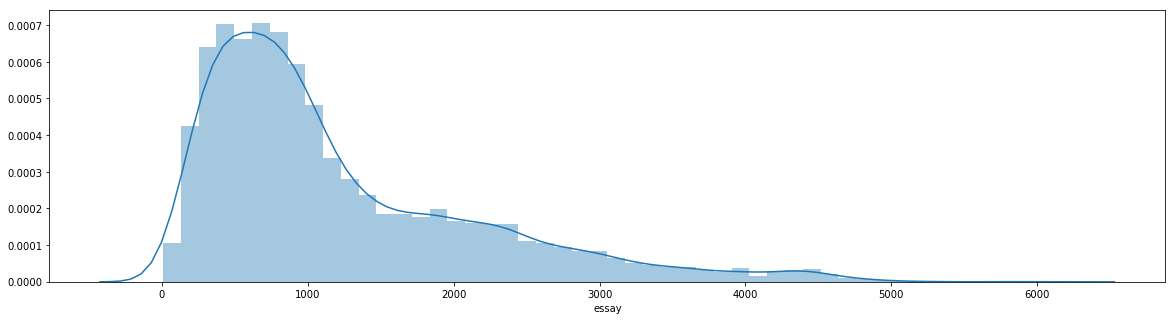

In [18]:
plt.figure(figsize=[20,5])
sns.distplot(df['essay'].apply(lambda x: len(x)))


Let's get the average length.

In [19]:
np.mean(df['essay'].apply(lambda x: len(x)))

1215.8712337211991

Let's see the distribution of total scores per essay set. 

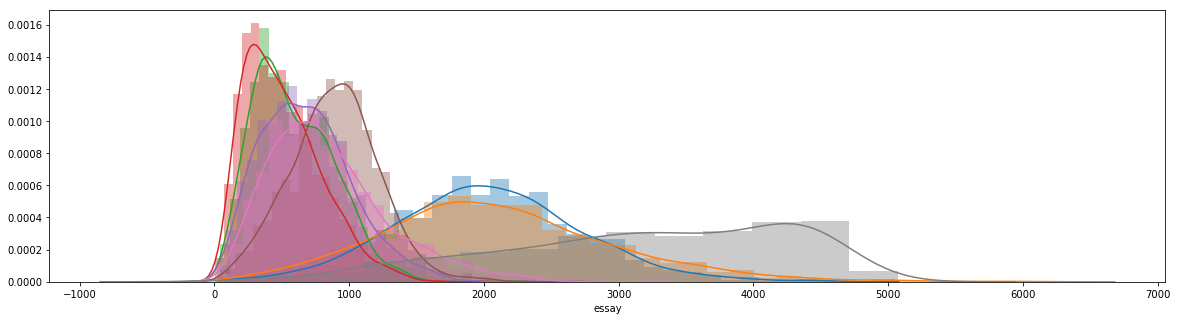

In [20]:
plt.figure(figsize=[20,5])

for i in range(1,9):
    sns.distplot(df[df['essay_set']==i]['essay'].apply(lambda x: len(x)))



In [21]:
df['len'] = df['essay'].apply(lambda x: len(x))

Let's see the boxplot distribution of length by essay set. 

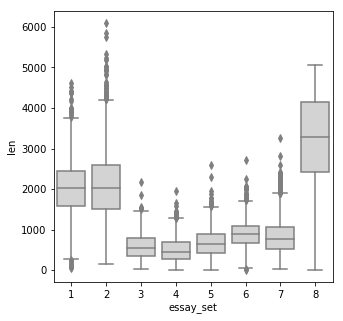

In [22]:
plt.figure(figsize=[5,5])
sns.boxplot(y="len", x="essay_set", data=df, color='lightgray');



To get a better idea of the difference between the essay sets. We did an exploratory data analysis on the difference between essay lengths and scores for each essay set.

From Figure 1, by visual observation, we can see three patterns of distributions. The essay sets 1 and 2 have similar medians and length ranges. Both sets 1 and 2 also have numerous outliers beyond the maximum. We see that essay sets 3, 4, 5, 6, 7 have narrower distributions than set 1, 2, 8. We see that essay set 8 is left-skewed and has fewer outliers than the other essay sets. 

Let's see the boxplot distribution of scores by essay set. 

In [23]:
from statannot import add_stat_annotation


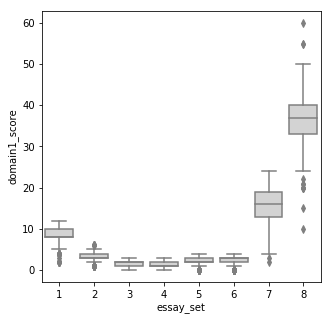

In [24]:
plt.figure(figsize=[5,5])
sns.boxplot(y="domain1_score", x="essay_set", data=df, color='lightgray');



Let's conduct a t-test to see the significane with a p-value of 5%. Bonferroni correction is used.
Null hypothesis: essay set does not matter to the scores.
Alternative hypothesis: essay set matters to the scores.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1 v.s. 2: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=1.258e+02
2 v.s. 3: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=5.855e+01
3 v.s. 4: t-test independent samples with Bonferroni correction, P_val=6.976e-42 stat=1.399e+01
4 v.s. 5: t-test independent samples with Bonferroni correction, P_val=3.601e-181 stat=-3.058e+01
5 v.s. 6: t-test independent samples with Bonferroni correction, P_val=3.278e-20 stat=-9.622e+00
6 v.s. 7: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=-1.204e+02
7 v.s. 8: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=-9.325e+01
1 v.s. 3: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=1.600e+02
2 v.s. 4: t-test independent samples with Bonferroni correction

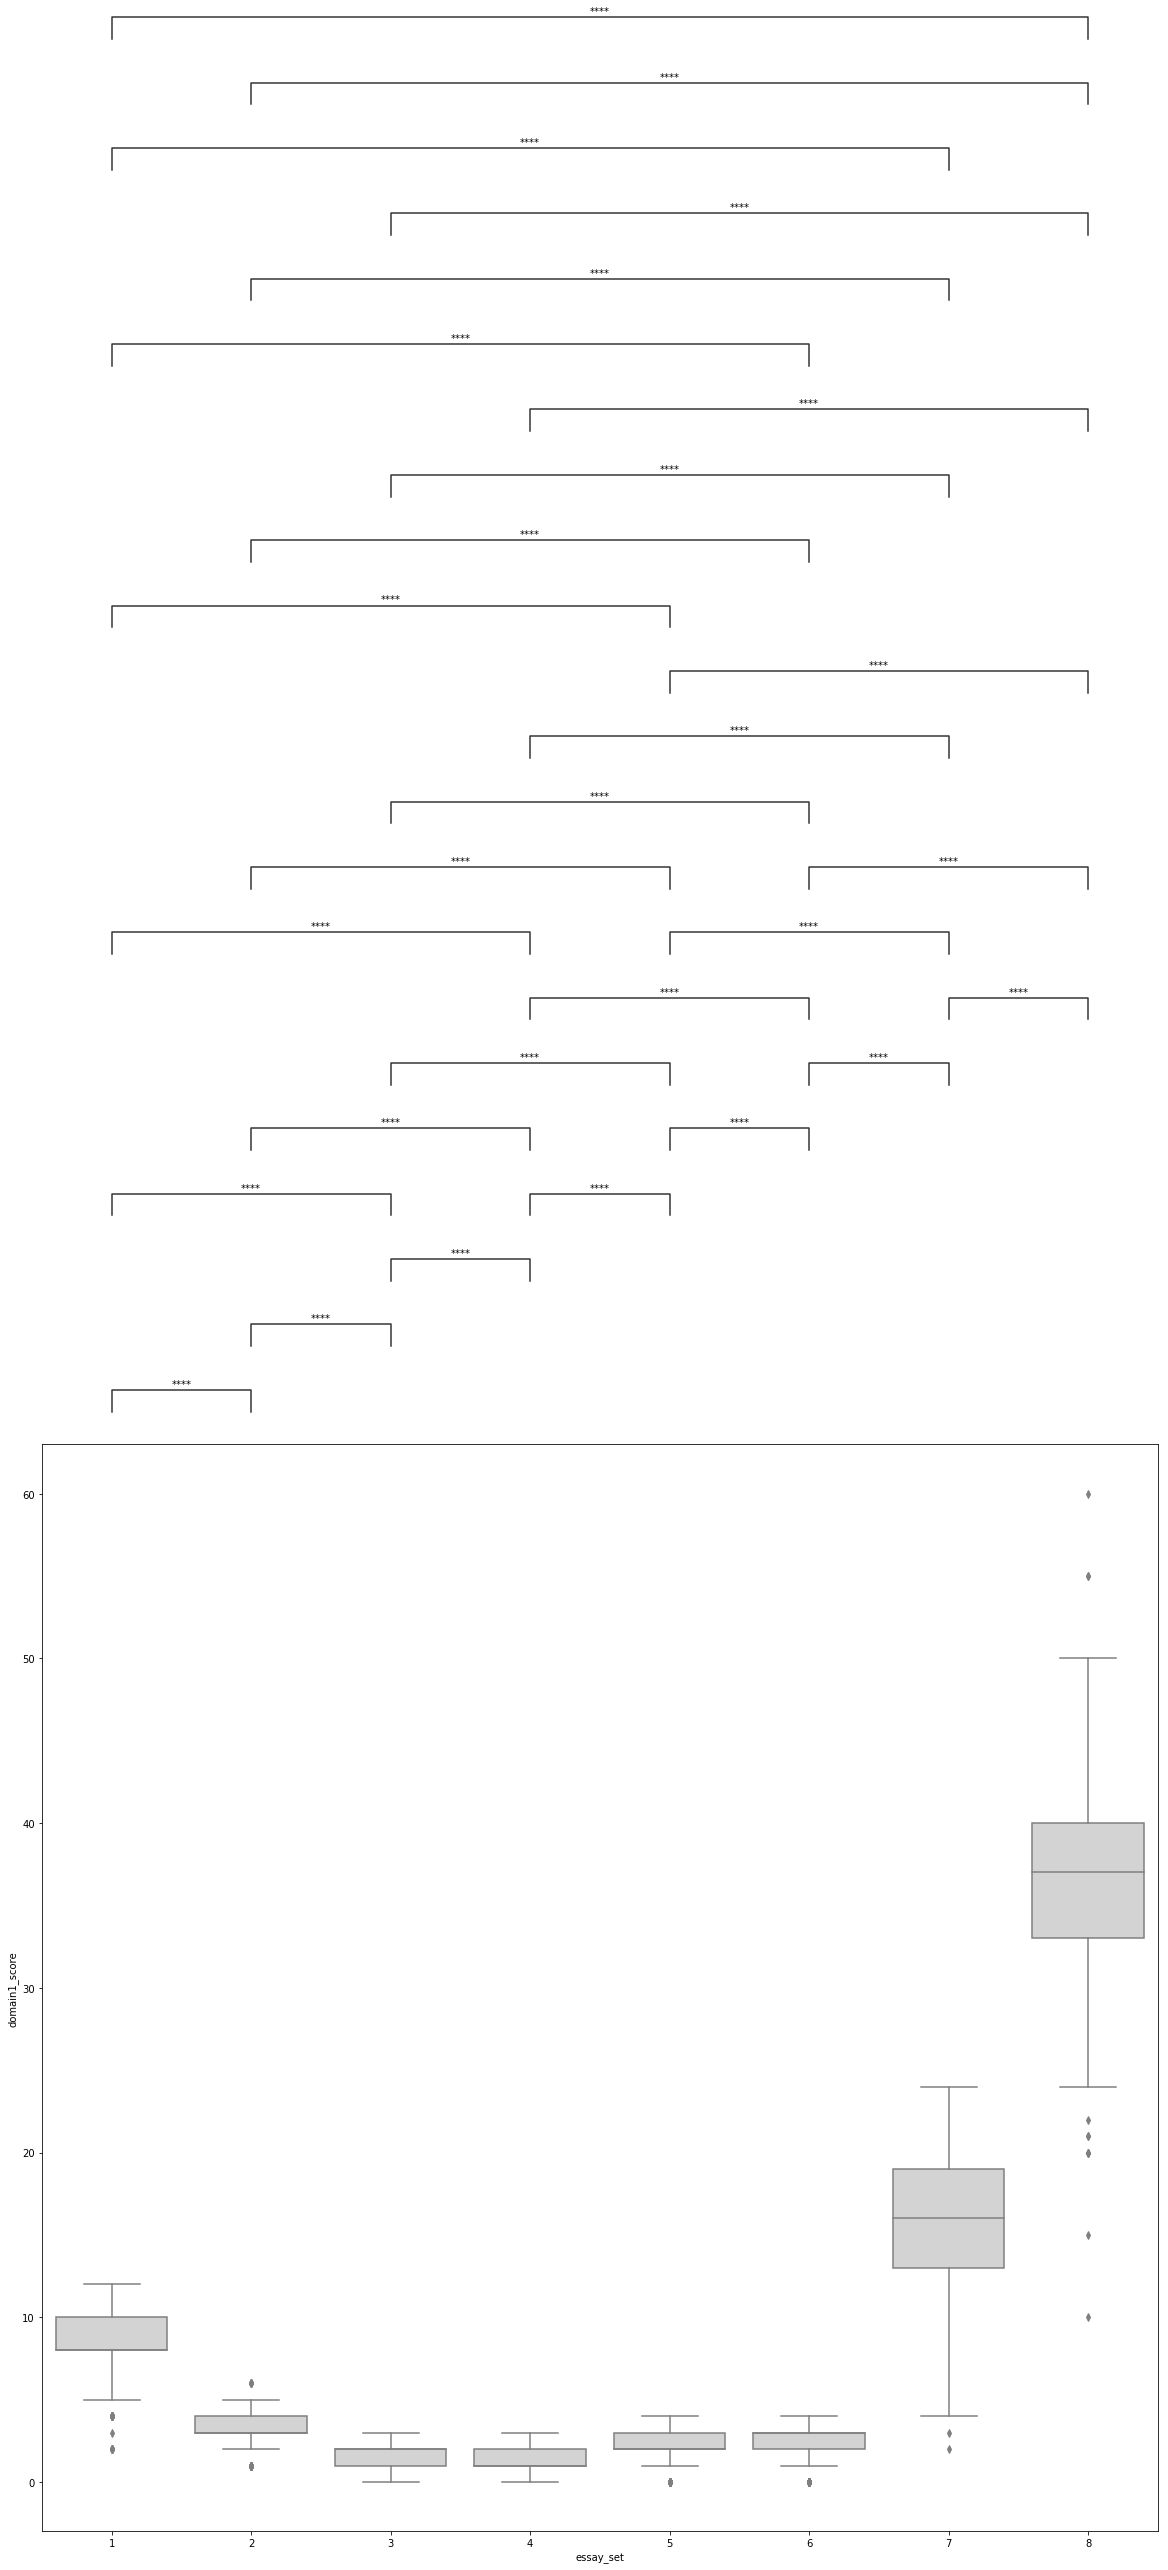

In [27]:
plt.figure(figsize=[20,20])
ax = sns.boxplot(y="domain1_score", x="essay_set", data=df, color='lightgray');
add_stat_annotation(ax, data=df, x='essay_set', y='domain1_score',
                    box_pairs=[(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8),
                              (2,3), (2,4), (2,5), (2,6), (2,7), (2,8),
                              (3,4), (3,5), (3,6), (3,7), (3,8),
                              (4,5), (4,6), (4,7), (4,8),
                              (5,6), (5,7), (5,8),
                              (6,7), (6,8),
                              (7,8)],
                    test='t-test_ind', text_format='star', loc='outside', verbose=2);

We reject the null hypothesis because our t-tests show that it is significant with p <= 1.00e-04.



In Figure 2, we wanted to see whether the essay set identification would be a good feature for our model. We applied statistical analysis with a null hypothesis that the essay set is not significant in predicting the score with a p-value of 5\%. Using a t-test independent test with Bonferroni correction, we saw that all essay sets are significant with p-values of <= 1.00e-04\%. This shows that this feature will be useful for our analytical dataset.


# Feature Engineering

We extracted two main types of features. We name the two types of features as non-textual and textual features. Non-textual pertains to the numeric features that we derive from the syntactic analysis of the text. Textual features pertain to the vectorized representation of the text. Here we used a document embedding approach.

Non-Textual Features

The non-textual features consist of 16 features. It is inspired by the baseline model used by Taghipour et al. in their paper using the open-source library EASE (Enhanced AI Scoring Engine) that extracts features from texts (Taghipour et al., 2016). The non-textual features are extracted from the normalized essays except for the number of stop words feature.
First, we got length based features of the essay. We got the number of words, number of sentences, number of characters, average length of words, and average sentence length. The intuition of these features is to extract the basic structure of the essay in terms of length.

We also extracted features reflecting the quality of the words used by the student. We extracted the number of stopwords, the number of unique words or the size of vocabulary, and the number of lemmas. The intuition of these features is to extract information on the richness or diversity of the student’s vocabulary. The features intend to extract whether the essay is made up of meaningful words or just stop words and/or repeating root words.

As a proxy to the quality of writing, we extracted the number of spelling errors in the essay. The intuition behind this is to extract a feature that indicates the grammar of the essays. We obtained spelling errors using the library pyspellchecker (Barrus, 2018).

We also got the counts of different POS tags of the essays. We got the number of nouns, adjectives, verbs, adverbs, and binned together other parts of speech. These features intend to capture the structure of the essay as well.

Given the text “I am at home. I am not in school. I am presenting my project. I am explaining.”, we wanted to extract a feature that derives the repetitiveness of n-gram usage of the writer. To do this, we derived the collocation likelihood ratio of n-grams. We computed the feature by getting the average of all likelihood ratios of all n-grams in the essays. We did this for both bi-grams and tri-grams in the essays.


Textual Features

Traditional fixed-length vector representations of text are done using bag-of-words. However, this approach does not preserve the semantics of the text in the vector representation. They addressed this issue with their Paragraph Vector Distributed Bag of Words (PV-DBOW), which predicts the context word from the paragraph vector (Le & Mikolov, 2014). 


We used gensim’s doc2vec in our implementation of the document embedding (Řehůřek & Sojka, 2010). For the window, we used a window of two which means we take into consideration two words before and two words after. For the vector size, we followed the general rule of thumb discussed by TensorFlow by getting the 4th root of the vocabulary size as the vector size (TensorFlow Team, 2017).

\begin{align} \label{Equation 3}
{vector size} = \sqrt[4]{vocabulary size}  
\end{align}

We used the essay sets feature as is. We hypothesize that advanced machine learning architectures will be able to distinguish and separate the evaluation of the essay given the information on what essay set it belongs to. This is important because different essay sets have different prompts. They have different score ranges and have different rubrics for scoring. using this as a feature This gives us a total of 32 features.

Remove the two rates because our target variable is the total score.

In [183]:
df = df.drop(['rater1_domain1','rater2_domain1'], axis=1)

Start with normalizing the essays.

In [184]:
def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = word_tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words] 
    doc = ' '.join(filtered_tokens)
    return doc

In [185]:
df['norm_essay'] = df['essay'].progress_apply(normalize_document)

Create function to extract features.

In [186]:
def stopword_count(doc):
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip() 
    tokens = word_tokenize(doc)
    stop_word_tokens = [token for token in tokens if token in stop_words] 
    return len(stop_word_tokens)

def number_of_words(doc):
    tokens = word_tokenize(doc)
    return len(tokens)

def unique_words(doc):
    tokens = word_tokenize(doc)
    return len(set(tokens))

def number_of_sentences(doc):
    tokens = sent_tokenize(doc)
    return len(tokens)

def number_of_char(doc):
    return len(doc)

def length_of_words(doc):
    tokens = word_tokenize(doc)
    return np.mean([len(word) for word in tokens])

def length_of_sentence(doc):
    tokens = sent_tokenize(doc)
    return np.mean([len(sentence) for sentence in tokens])

def vocabulary(df):
    doc = " ".join(df['essay'])
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = word_tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words] 
    vocabulary = set(filtered_tokens)
    return vocabulary

def count_spell_error(doc):
    from spellchecker import SpellChecker
    spell = SpellChecker()
    misspelled = spell.unknown(word_tokenize(doc))
    return len(misspelled)
    
#     tokens = word_tokenize(doc)
#     text_blob_object = TextBlob(doc)
#     corrected_tokens = list(text_blob_object.correct().words)
#     return corrected_tokens #np.sum(np.asarray(tokens) != np.asarray(corrected_tokens))

def count_pos(essay):
    tokenized_sentences = sent_tokenize(essay)
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0
    others_count = 0
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)
        
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                noun_count += 1
            elif pos_tag.startswith('J'):
                adj_count += 1
            elif pos_tag.startswith('V'):
                verb_count += 1
            elif pos_tag.startswith('R'):
                adv_count += 1
            else:
                others_count += 1
            
    return noun_count, adj_count, verb_count, adv_count, others_count
    

def count_lemmas(essay):
    tokenized_sentences = sent_tokenize(essay)      
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence) 
        
        for token_tuple in tagged_tokens:
        
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
    lemma_count = len(set(lemmas))
    return lemma_count

def bigram_assoc(doc):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(word_tokenize(doc))
    likelihood = finder.score_ngrams(bigram_measures.likelihood_ratio)
    return np.mean([y for x, y in likelihood])

def trigram_assoc(doc):
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = TrigramCollocationFinder.from_words(word_tokenize(doc))
    likelihood = finder.score_ngrams(trigram_measures.likelihood_ratio)
    return np.mean([y for x, y in likelihood])

# Number of POS (superlatives)?



Generated Document embeddings from the text. Use 4th root as the vector size as per Tensorflow.

In [187]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
vocab_size = np.ceil(len(vocabulary(df))**0.25)
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['essay'])]
model = Doc2Vec(documents, vector_size=15, window=2, min_count=1, workers=4)

In [189]:
doc_vec = pd.DataFrame([model[i] for i, doc in enumerate(df['essay'])])
doc_vec.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
12972,-0.320935,0.012456,-0.025385,0.780093,0.215207,-0.352793,0.476044,-0.186473,0.123534,-0.335186,-0.630423,-0.156503,-0.233736,0.160355,0.358908
12973,0.117255,0.181189,0.601422,0.200848,0.253331,-0.146354,0.377034,-0.510333,0.795553,-0.127100,-0.122341,-0.534177,0.129022,0.011495,0.203058
12974,0.017339,0.215585,0.229645,0.388529,0.255853,-0.271206,0.184585,-0.446037,0.188912,-0.388642,0.241516,-0.713013,0.340188,0.136942,-0.011868
12975,-0.460425,0.090618,0.063405,0.582545,0.175946,-0.279936,0.025638,-0.518726,0.322320,0.002700,0.450240,-0.188246,0.079544,0.187945,-0.387018
12976,-0.110074,-0.129783,-0.146371,0.318639,0.395851,-0.153366,0.206153,0.005529,-0.242419,-0.121458,0.685859,-0.337146,0.200147,-0.266011,-0.110837


In [190]:
vecs = ['embed_'+str(i) for i in range(15)]
vecs

doc_vec.columns = vecs

In [191]:
print(doc_vec.shape)
display(doc_vec.head(2))
display(doc_vec.tail(2))

(12977, 15)


,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,embed_10,embed_11,embed_12,embed_13,embed_14
0,-0.225837,0.127403,-0.000037,0.440711,0.168277,0.406001,0.036745,-0.015098,0.137470,-0.351160,0.260943,-0.273236,0.159757,0.168239,0.037946
1,-0.260166,0.028514,-0.276629,0.333466,0.880479,0.566253,0.591811,-0.015257,0.446866,-0.395379,0.841059,0.094705,0.563873,0.823062,0.846773


,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,embed_9,embed_10,embed_11,embed_12,embed_13,embed_14
12975,-0.460425,0.090618,0.063405,0.582545,0.175946,-0.279936,0.025638,-0.518726,0.322320,0.002700,0.450240,-0.188246,0.079544,0.187945,-0.387018
12976,-0.110074,-0.129783,-0.146371,0.318639,0.395851,-0.153366,0.206153,0.005529,-0.242419,-0.121458,0.685859,-0.337146,0.200147,-0.266011,-0.110837


In [99]:
def extract_features(data):
    features = data.copy()
    features['noun_count'], features['adj_count'], features['verb_count'], features['adv_count'], features['others_count'] = zip(*features['norm_essay'].progress_apply(count_pos))
    features['stopword_count'] = features['essay'].progress_apply(stopword_count)
    features['number_of_words'] = features['norm_essay'].progress_apply(number_of_words)
    features['number_of_sentences'] = features['essay'].progress_apply(number_of_sentences)
    features['number_of_char'] = features['norm_essay'].progress_apply(number_of_char)
    features['length_of_words'] = features['norm_essay'].progress_apply(length_of_words)
    features['length_of_sentence'] = features['norm_essay'].progress_apply(length_of_sentence)
    features['unique_words'] = features['norm_essay'].progress_apply(unique_words)
    features['count_spell_error'] = features['norm_essay'].progress_apply(count_spell_error)
    features['count_lemmas'] = features['norm_essay'].progress_apply(count_lemmas)
    features['bigram_assoc'] = features['norm_essay'].progress_apply(bigram_assoc)
    features['trigram_assoc'] = features['norm_essay'].progress_apply(trigram_assoc)
    return features

Apply the feature engineering functions.

In [100]:
features = extract_features(df)
  

/home/msds2020/vayu/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


The feature engineering ran for 50 minutes in jojie.

In [102]:
features

,essay_set,essay,domain1_score,norm_essay,noun_count,adj_count,verb_count,adv_count,others_count,stopword_count,number_of_words,number_of_sentences,number_of_char,length_of_words,length_of_sentence,unique_words,count_spell_error,count_lemmas,bigram_assoc,trigram_assoc
0,1,"Dear local newspaper, I think effects computer...",8.0,dear local newspaper think effects computers p...,800,105,137,1,71,174,163,16,1114,5.840491,1114.0,111,15,25,9.421474,31.610003
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,dear caps caps believe using computers benefit...,1064,150,186,1,98,193,226,20,1499,5.637168,1499.0,134,16,26,9.048174,32.256725
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,dear caps caps caps people use computers every...,694,110,109,1,60,140,139,14,974,6.014388,974.0,95,2,26,8.433139,28.500499
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0,dear local newspaper caps found many experts s...,1538,232,220,2,162,224,300,27,2154,6.183333,2154.0,176,23,27,8.986006,31.212702
4,1,"Dear @LOCATION1, I know having computers has a...",8.0,dear location know computers positive effect p...,1049,177,215,0,125,240,225,30,1566,5.964444,1566.0,136,10,25,8.612725,29.487946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12973,8,In most stories mothers and daughters are eit...,35.0,stories mothers daughters either enemies frien...,1902,249,298,3,199,414,430,27,2651,5.167442,2651.0,239,5,26,9.060433,32.344761
12974,8,I never understood the meaning laughter is th...,32.0,never understood meaning laughter shortest dis...,1175,172,179,1,122,268,277,35,1649,4.956679,1649.0,148,11,26,8.145293,28.739240
12975,8,"When you laugh, is @CAPS5 out of habit, or is ...",40.0,laugh caps habit caps cause causes laughing ca...,1932,297,322,5,203,415,401,41,2759,5.882793,2759.0,265,13,27,9.936673,32.848928
12976,8,Trippin' on fen...,40.0,trippin fences num years young short num years...,1225,171,207,3,168,299,263,39,1774,5.749049,1774.0,167,5,26,9.877766,33.627558


In [689]:
features.head()

,essay_set,essay,domain1_score,norm_essay,noun_count,adj_count,verb_count,adv_count,others_count,stopword_count,number_of_words,number_of_sentences,number_of_char,length_of_words,length_of_sentence,unique_words,count_spell_error,count_lemmas,bigram_assoc,trigram_assoc
0,1,"Dear local newspaper, I think effects computer...",8.0,dear local newspaper think effects computers p...,800,105,137,1,71,174,163,16,1114,5.840491,1114.0,111,15,25,9.421474,31.610003
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,dear caps caps believe using computers benefit...,1064,150,186,1,98,193,226,20,1499,5.637168,1499.0,134,16,26,9.048174,32.256725
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0,dear caps caps caps people use computers every...,694,110,109,1,60,140,139,14,974,6.014388,974.0,95,2,26,8.433139,28.500499
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0,dear local newspaper caps found many experts s...,1538,232,220,2,162,224,300,27,2154,6.183333,2154.0,176,23,27,8.986006,31.212702
4,1,"Dear @LOCATION1, I know having computers has a...",8.0,dear location know computers positive effect p...,1049,177,215,0,125,240,225,30,1566,5.964444,1566.0,136,10,25,8.612725,29.487946


In [199]:
# import pickle

# with open('features.pickle','wb') as f:
#     pickle.dump(features, f)

In [164]:
df.shape

(12977, 4)

In [193]:
features.isnull().sum()

essay_set              0
essay                  0
domain1_score          0
norm_essay             0
noun_count             0
adj_count              0
verb_count             0
adv_count              0
others_count           0
stopword_count         0
number_of_words        0
number_of_sentences    0
number_of_char         0
length_of_words        0
length_of_sentence     0
unique_words           0
count_spell_error      0
count_lemmas           0
bigram_assoc           2
trigram_assoc          5
dtype: int64

Combine the features generated into one analytical dataset.

In [194]:
df_model = pd.concat([features, doc_vec], axis=1)

display(df_model.head(2))
display(df_model.tail(2))

,essay_set,essay,domain1_score,norm_essay,noun_count,adj_count,verb_count,adv_count,others_count,stopword_count,...,embed_5,embed_6,embed_7,embed_8,embed_9,embed_10,embed_11,embed_12,embed_13,embed_14
0,1,"Dear local newspaper, I think effects computer...",8.0,dear local newspaper think effects computers p...,800,105,137,1,71,174,...,0.406001,0.036745,-0.015098,0.137470,-0.351160,0.260943,-0.273236,0.159757,0.168239,0.037946
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0,dear caps caps believe using computers benefit...,1064,150,186,1,98,193,...,0.566253,0.591811,-0.015257,0.446866,-0.395379,0.841059,0.094705,0.563873,0.823062,0.846773


,essay_set,essay,domain1_score,norm_essay,noun_count,adj_count,verb_count,adv_count,others_count,stopword_count,...,embed_5,embed_6,embed_7,embed_8,embed_9,embed_10,embed_11,embed_12,embed_13,embed_14
12975,8,Trippin' on fen...,40.0,trippin fences num years young short num years...,1225,171,207,3,168,299,...,-0.279936,0.025638,-0.518726,0.322320,0.002700,0.450240,-0.188246,0.079544,0.187945,-0.387018
12976,8,Many people believe that laughter can improve...,40.0,many people believe laughter improve life laug...,1074,137,199,3,143,243,...,-0.153366,0.206153,0.005529,-0.242419,-0.121458,0.685859,-0.337146,0.200147,-0.266011,-0.110837


In [196]:
df_model.columns

Index(['essay_set', 'essay', 'domain1_score', 'norm_essay', 'noun_count',
       'adj_count', 'verb_count', 'adv_count', 'others_count',
       'stopword_count', 'number_of_words', 'number_of_sentences',
       'number_of_char', 'length_of_words', 'length_of_sentence',
       'unique_words', 'count_spell_error', 'count_lemmas', 'bigram_assoc',
       'trigram_assoc', 'embed_0', 'embed_1', 'embed_2', 'embed_3', 'embed_4',
       'embed_5', 'embed_6', 'embed_7', 'embed_8', 'embed_9', 'embed_10',
       'embed_11', 'embed_12', 'embed_13', 'embed_14'],
      dtype='object')

In [197]:
columnsTitles = ['essay','norm_essay','essay_set',
'noun_count',           'adj_count',
'verb_count',           'adv_count',        'others_count',
'stopword_count',     'number_of_words', 'number_of_sentences',
'number_of_char',     'length_of_words',  'length_of_sentence',
'unique_words',   'count_spell_error',        'count_lemmas',
'bigram_assoc',       'trigram_assoc',  'embed_0', 'embed_1', 'embed_2', 'embed_3', 'embed_4',
'embed_5', 'embed_6', 'embed_7', 'embed_8', 'embed_9', 'embed_10',
'embed_11', 'embed_12', 'embed_13', 'embed_14', 'domain1_score']
df_model = df_model.reindex(columns=columnsTitles)
df_model.head()

,essay,norm_essay,essay_set,noun_count,adj_count,verb_count,adv_count,others_count,stopword_count,number_of_words,...,embed_6,embed_7,embed_8,embed_9,embed_10,embed_11,embed_12,embed_13,embed_14,domain1_score
0,"Dear local newspaper, I think effects computer...",dear local newspaper think effects computers p...,1,800,105,137,1,71,174,163,...,0.036745,-0.015098,0.137470,-0.351160,0.260943,-0.273236,0.159757,0.168239,0.037946,8.0
1,"Dear @CAPS1 @CAPS2, I believe that using compu...",dear caps caps believe using computers benefit...,1,1064,150,186,1,98,193,226,...,0.591811,-0.015257,0.446866,-0.395379,0.841059,0.094705,0.563873,0.823062,0.846773,9.0
2,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",dear caps caps caps people use computers every...,1,694,110,109,1,60,140,139,...,0.407132,0.081580,0.352523,-0.843449,0.506814,-0.145217,0.418992,0.617335,0.283492,7.0
3,"Dear Local Newspaper, @CAPS1 I have found that...",dear local newspaper caps found many experts s...,1,1538,232,220,2,162,224,300,...,-0.037924,0.182144,0.269080,-0.474262,0.279691,0.062842,0.047124,1.018683,0.422164,10.0
4,"Dear @LOCATION1, I know having computers has a...",dear location know computers positive effect p...,1,1049,177,215,0,125,240,225,...,0.464000,-0.103586,0.425969,-0.364437,0.995853,-0.256567,0.704938,0.826637,0.687459,8.0


In [222]:

# with open('df_model.pickle','wb') as f:
#     pickle.dump(df_model, f)

# Machine Learning

For the discussion of traditional machine learning methods, we start by defining notations. Let $\mathbf{X} \in \mathbb{R}^{12976 \times 32}$ be the matrix of features, $\mathbf{y} \in \mathbb{R}^{12976}$ be the scores and $\mathbf{f} \in \mathbb{R}^{12976}$ be the predictions made by the models.

We then tested out deep learning models with fully connected deep networks, Long Short-term Memory (LSTM) networks, and a multiple data input ensemble of fully connected deep networks and LSTM. We also tested traditional machine learning models to establish a baseline using Gradient Boosted Regressor (GBR).

To train a model, we split $\mathbf{X}$ into $\mathbf{X}_{train} \in \mathbb{R}^{9732 \times 32}$ and $\mathbf{X}_{test} \in \mathbb{R}^{3244 \times 32}$, $\mathbf{y}_{train} \in \mathbb{R}^{9732}$ and $\mathbf{y}_{test} \in \mathbb{R}^{3244}$, i.e. 75-25 train test split. To evaluate the model, we get the QWK between the \mathbb{R}^{3244}$ and $\mathbf{f} \in \mathbb{R}^{3244}$ to get the agreement between the human raters and the machine learning model.

# Gradient Boosting

We wanted to try a traditional machine learning as well to establish a baseline. Friedman introduced a new regression technique called “Gradient Boosting Machines” (GBM) in 2001 (Friedman, 2001). This machine learning technique uses weak learners, typically decision trees, and combines them into a single strong learner iteratively as seen in Figure 10 (Shoaran, 2018). Weak learners are able to generalize and reduce overfitting that may occur in decision trees. In our implementation, we minimized the cost function, least squares (LS). In our implementation we used grid search to search through a given hyperparameter space. 



We chose to tune the parameters max\_depth, min\_samples\_split, max\_features, and learning rate to get the best performing GBR model using a grid search. The max\_depth is the maximum depth of the trees that we tune to control overfitting (Jain,2016). A lower number would result in a more generalized model. The min\_samples\_split is the minimum number of samples required for a node to split into branches (Jain,2016). This is tuned as well to control overfitting. Controlling this would make sure that the model will only learn relations that are evident in the samples. The max\_features is the maximum number of features to consider when searching for the best split (Jain,2016). These features are randomly selected just like in Random Forest Decision Trees. Controlling this would control overfitting and only learn from a percentage of the features. This also serves as an embedded feature reduction. The learning rate is able to indicate the contribution of each new base model and allows regularization (Hastie et al.,2001).

We then apply a grid search from a set of hyperparameters using 5-fold cross-validation to select the best model. The metric we use for performance is $r^2$ score defined by
\begin{equation}
    r^2 = 1- \frac{\sum_{i=1}^{1946} (y_i - f_i)^2}{\sum_{i=1}^{1946} (y_i - \bar{y})^2}.
\end{equation}
Note here that we only use 1946 data points as the validation set in cross validation since we take 20 percent in 5-fold CV. After obtaining the model with the best hyperparameters for each model, we use them to predict on the validation set and compute the resulting $r^2$ score as a measure of performance.

To interpret the decision making of the model, we get the feature importance summary plot using SHAP (SHapley Additive exPlanations). The summary plot plots the distribution of SHAP values for every feature for every sample. Higher SHAP values towards the right indicate a more positive relationship, and lower values to the left indicate a more negative relationship. The features are ranked from the most important feature to the least. The color represents the feature value, with higher values as red and lower values as blue (Lundberg, 2020). 

In [70]:
with open('df_model.pickle','rb') as f:
    df_model = pickle.load(f)

In [71]:
df_model = df_model.fillna(0)

In [72]:
df_model.iloc[:,2:-1].columns

Index(['essay_set', 'noun_count', 'adj_count', 'verb_count', 'adv_count',
       'others_count', 'stopword_count', 'number_of_words',
       'number_of_sentences', 'number_of_char', 'length_of_words',
       'length_of_sentence', 'unique_words', 'count_spell_error',
       'count_lemmas', 'bigram_assoc', 'trigram_assoc', 'embed_0', 'embed_1',
       'embed_2', 'embed_3', 'embed_4', 'embed_5', 'embed_6', 'embed_7',
       'embed_8', 'embed_9', 'embed_10', 'embed_11', 'embed_12', 'embed_13',
       'embed_14'],
      dtype='object')

In [73]:
X = df_model.iloc[:,2:-1].values
y = df_model.iloc[:,-1:].values


Random train test split 75-25

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [75]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [596]:
# Training a Gradient Boosting Regression model using all the features (BOW + other features)

params = {'max_depth':[4, 5, 6], 
          'min_samples_split': [2, 3, 4],
          'learning_rate':[1, 0.1, 0.3],
          'max_features': [.5,.3, .2],
          'loss': ['ls']}

# learning_rate_list = [.2, 0.1, 0.05, 0.02, 0.01]
# max_depth_list = [3, 4, 6, 8]
# min_samples_leaf_list = [2, 3, 4]
# max_features_list = [.5,.3, .2]

# 'n_estimators':[100, 1000], 
gbr = ensemble.GradientBoostingRegressor()

grid = GridSearchCV(gbr, params, n_jobs=-1, verbose=1, cv=5)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.4f" % mse)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))


Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  5.7min finished


0.9714382357932021
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=0.5, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
MSE: 2.3290
Variance score: 0.97
Cohen's kappa score: 0.45


In [597]:
cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')

0.9848169622581411

In [598]:
with open('model_ml1.pickle','wb') as f:
    pickle.dump(grid, f)

In [600]:
[grid.best_estimator_.score(X_train, y_train),
grid.best_estimator_.score(X_test, y_test),
grid.best_params_]

[0.991766708962657,
 0.9706739112917744,
 {'learning_rate': 0.1,
  'loss': 'ls',
  'max_depth': 6,
  'max_features': 0.5,
  'min_samples_split': 2}]

Save images of the trees for easy interpretation

In [667]:
# gradient lifting tree structure diagram
from sklearn import tree
import pydotplus 

# Draw the top ten trees and save them as png
# clf = ensemble.GradientBoostingRegressor(**params) , model training part omitted
for i in range(0,10):
    sub_tree = grid.best_estimator_.estimators_[i, 0]

    dot_data = tree.export_graphviz(
            sub_tree,
            out_file=None, filled=True,
            rounded=True,  
            special_characters=True,
            proportion=True, feature_names = df_model.iloc[:,2:-1].columns
            )

    graph = pydotplus.graph_from_dot_data(dot_data)  
    graph.write_png("tree"+str(i)+".png")

Interpret using SHAP

In [601]:
import shap
explainer = shap.TreeExplainer(grid.best_estimator_)

Top 15

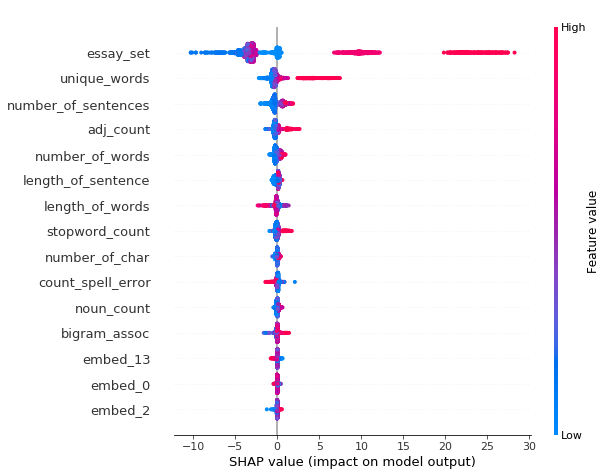

In [608]:
X_shap = pd.DataFrame(X_test)
X_shap.columns = df_model.iloc[:,2:-1].columns
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap, max_display=15)


All

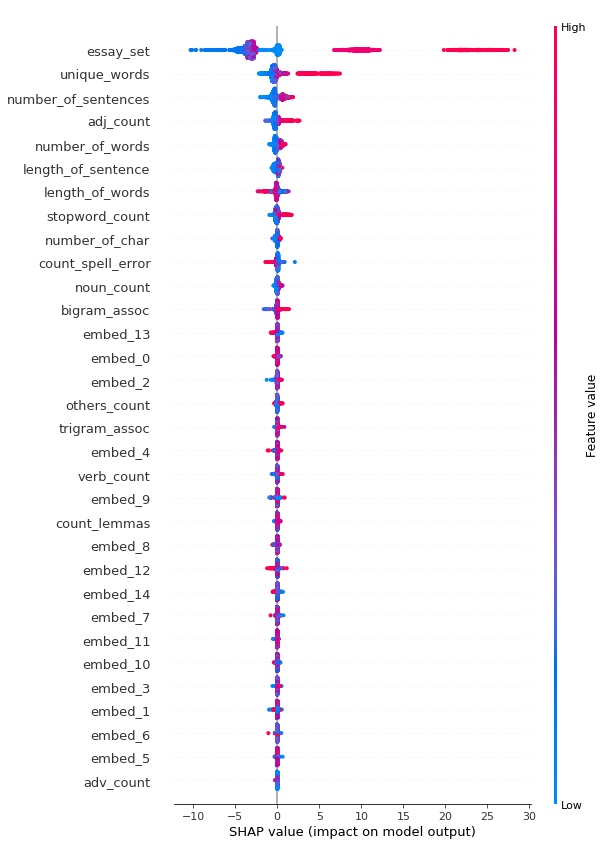

In [607]:
X_shap = pd.DataFrame(X_test)
X_shap.columns = df_model.iloc[:,2:-1].columns
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap, max_display=32)



In the SHAP plot, we can see that the top 3 most important features are the essay set, the number of unique words or vocabulary size, and the number of sentences. The essay set importance agrees with our EDA that the feature is indeed significant. Not only does this show the significance of the feature but it also shows the effectiveness of the model to split the data using the essay set feature. It is evident that there are some essay sets with higher feature values that have a negative impact on the prediction. 

The summary plot shows that the extracted non-textual features ranked higher in terms of importance. We can see that a higher number of unique words resulted in higher scores. We also saw that a higher adjective count resulted in higher scores, which can show the vividness of the storytelling skill of the student.

# Fully Connected Deep Networks

Fully connected deep networks are one of the most basic types of neural networks. It is “structure agnostic”, which indicates that it does have any assumption on the input to the network. This feature makes it easy to generalize through different use cases (Ramsundar et al., 2018). The structure of the model can be seen in Figure 6 (Teichert, 2018). We implemented our model through Keras. The Keras package allowed us to benefit from the optimized parameter tuning of Keras and Tensorflow (Chollet, 2015).


The input data into our fully connected deep network regressor are the 32 features generated. We implemented multiple architectures of the models. We tested wider and deeper neural networks to see which architecture would achieve the best accuracy. We increased the number of hidden units as the number of layers increased such that the hidden units will decrease for every succeeding layer. The number of hidden units was determined by $2^n$.



Let's first go Wider and see the accuracy.

## Wider

In [63]:
def build_model():
    model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[X_train.shape[1],]),
#     layers.Dense(64, activation='relu'),
    layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model
model = build_model()
model.summary()
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1
)
y_pred = model.predict(X_test)
cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
_________________________________________________________________
Train on 8758 samples, validate on 974 samples
Epoch 1/100
8758/8758 [==============================] - 1s 171us/sample - loss: 137.6968 - mae: 7.3593 - mse: 137.6968 - val_loss: 84.4687 - val_mae: 5.8417 - val_mse: 84.4687
Epoch 2/100
8758/8758 [==============================] - 1s 97us/sample - loss: 73.1736 - mae: 5.6739 - mse: 73.1736 - val_loss: 61.6613 - val_mae: 5.3420 - val_mse: 61.6613
Epoch 3/100
8758/8758 [==============================] - 1s 94us/sample - loss: 54.7773 - mae: 4.9032 - mse: 54.7772

Epoch 44/100
8758/8758 [==============================] - 1s 105us/sample - loss: 15.3216 - mae: 2.8428 - mse: 15.3216 - val_loss: 17.2508 - val_mae: 3.2096 - val_mse: 17.2508
Epoch 45/100
8758/8758 [==============================] - 1s 105us/sample - loss: 14.2121 - mae: 2.7450 - mse: 14.2121 - val_loss: 11.5265 - val_mae: 2.5414 - val_mse: 11.5265
Epoch 46/100
8758/8758 [==============================] - 1s 105us/sample - loss: 15.3321 - mae: 2.8519 - mse: 15.3322 - val_loss: 11.7766 - val_mae: 2.5165 - val_mse: 11.7766
Epoch 47/100
8758/8758 [==============================] - 1s 104us/sample - loss: 13.6467 - mae: 2.6714 - mse: 13.6467 - val_loss: 12.3564 - val_mae: 2.5421 - val_mse: 12.3564
Epoch 48/100
8758/8758 [==============================] - 1s 107us/sample - loss: 15.0945 - mae: 2.8043 - mse: 15.0945 - val_loss: 19.3211 - val_mae: 3.0336 - val_mse: 19.3211
Epoch 49/100
8758/8758 [==============================] - 1s 107us/sample - loss: 15.6194 - mae: 2.8470 - mse: 15.6194 -

Epoch 91/100
8758/8758 [==============================] - 1s 111us/sample - loss: 9.6156 - mae: 2.1296 - mse: 9.6156 - val_loss: 7.7107 - val_mae: 1.9696 - val_mse: 7.7107
Epoch 92/100
8758/8758 [==============================] - 1s 102us/sample - loss: 8.8104 - mae: 2.0476 - mse: 8.8104 - val_loss: 8.0369 - val_mae: 2.0610 - val_mse: 8.0369
Epoch 93/100
8758/8758 [==============================] - 1s 107us/sample - loss: 9.4923 - mae: 2.1074 - mse: 9.4923 - val_loss: 21.9342 - val_mae: 3.3448 - val_mse: 21.9342
Epoch 94/100
8758/8758 [==============================] - 1s 104us/sample - loss: 9.5982 - mae: 2.1153 - mse: 9.5981 - val_loss: 9.7312 - val_mae: 2.2600 - val_mse: 9.7312
Epoch 95/100
8758/8758 [==============================] - 1s 106us/sample - loss: 11.9548 - mae: 2.3064 - mse: 11.9548 - val_loss: 7.7106 - val_mae: 1.9566 - val_mse: 7.7106
Epoch 96/100
8758/8758 [==============================] - 1s 102us/sample - loss: 11.0111 - mae: 2.2775 - mse: 11.0111 - val_loss: 8.381

0.9479812988880199

## Wider 64

In [64]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1],]),
    layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model
model = build_model()
model.summary()
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1
)
y_pred = model.predict(X_test)
cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 2,177
Trainable params: 2,177
Non-trainable params: 0
_________________________________________________________________
Train on 8758 samples, validate on 974 samples
Epoch 1/100
8758/8758 [==============================] - 1s 167us/sample - loss: 555.1943 - mae: 11.7053 - mse: 555.1942 - val_loss: 137.8171 - val_mae: 7.1767 - val_mse: 137.8171
Epoch 2/100
8758/8758 [==============================] - 1s 103us/sample - loss: 101.4081 - mae: 6.5694 - mse: 101.4081 - val_loss: 148.0545 - val_mae: 7.4629 - val_mse: 148.0544
Epoch 3/100
8758/8758 [==============================] - 1s 107us/sample - loss: 66.2124 - mae: 5.2508 - mse

Epoch 44/100
8758/8758 [==============================] - 1s 103us/sample - loss: 17.3303 - mae: 2.9204 - mse: 17.3303 - val_loss: 13.6367 - val_mae: 2.7293 - val_mse: 13.6367
Epoch 45/100
8758/8758 [==============================] - 1s 101us/sample - loss: 16.1668 - mae: 2.8431 - mse: 16.1668 - val_loss: 14.1775 - val_mae: 2.8004 - val_mse: 14.1775
Epoch 46/100
8758/8758 [==============================] - 1s 94us/sample - loss: 15.1831 - mae: 2.7395 - mse: 15.1831 - val_loss: 11.8919 - val_mae: 2.4276 - val_mse: 11.8919
Epoch 47/100
8758/8758 [==============================] - 1s 90us/sample - loss: 15.8339 - mae: 2.7907 - mse: 15.8339 - val_loss: 13.7733 - val_mae: 2.6467 - val_mse: 13.7733
Epoch 48/100
8758/8758 [==============================] - 1s 95us/sample - loss: 13.9290 - mae: 2.6261 - mse: 13.9290 - val_loss: 11.1194 - val_mae: 2.3789 - val_mse: 11.1194
Epoch 49/100
8758/8758 [==============================] - 1s 109us/sample - loss: 14.7579 - mae: 2.7176 - mse: 14.7579 - va

Epoch 91/100
8758/8758 [==============================] - 1s 91us/sample - loss: 8.4103 - mae: 1.9657 - mse: 8.4103 - val_loss: 11.1916 - val_mae: 2.3182 - val_mse: 11.1916
Epoch 92/100
8758/8758 [==============================] - 1s 99us/sample - loss: 10.5567 - mae: 2.1820 - mse: 10.5567 - val_loss: 10.3946 - val_mae: 2.1166 - val_mse: 10.3946
Epoch 93/100
8758/8758 [==============================] - 1s 105us/sample - loss: 11.1501 - mae: 2.2574 - mse: 11.1501 - val_loss: 8.3070 - val_mae: 1.9692 - val_mse: 8.3070
Epoch 94/100
8758/8758 [==============================] - 1s 105us/sample - loss: 8.4837 - mae: 1.9684 - mse: 8.4837 - val_loss: 7.2968 - val_mae: 1.7970 - val_mse: 7.2968
Epoch 95/100
8758/8758 [==============================] - 1s 103us/sample - loss: 10.4596 - mae: 2.1708 - mse: 10.4596 - val_loss: 28.6838 - val_mae: 3.7607 - val_mse: 28.6838
Epoch 96/100
8758/8758 [==============================] - 1s 95us/sample - loss: 9.7676 - mae: 2.0887 - mse: 9.7676 - val_loss: 8.

0.9491731968233293

## Wider 128

In [65]:
def build_model():
    model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train.shape[1],]),
    layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model
model = build_model()
model.summary()
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1
)
y_pred = model.predict(X_test)
cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________
Train on 8758 samples, validate on 974 samples
Epoch 1/100
8758/8758 [==============================] - 2s 201us/sample - loss: 3954.5294 - mae: 19.3733 - mse: 3954.5303 - val_loss: 70.8008 - val_mae: 5.5501 - val_mse: 70.8008
Epoch 2/100
8758/8758 [==============================] - 1s 92us/sample - loss: 59.6369 - mae: 5.2237 - mse: 59.6369 - val_loss: 55.1329 - val_mae: 4.5436 - val_mse: 55.1329
Epoch 3/100
8758/8758 [==============================] - 1s 89us/sample - loss: 45.9810 - mae: 4.6125 - mse: 45.9

Epoch 44/100
8758/8758 [==============================] - 1s 112us/sample - loss: 12.3097 - mae: 2.3056 - mse: 12.3097 - val_loss: 11.6262 - val_mae: 2.1715 - val_mse: 11.6263
Epoch 45/100
8758/8758 [==============================] - 1s 99us/sample - loss: 12.5843 - mae: 2.3943 - mse: 12.5843 - val_loss: 13.0126 - val_mae: 2.3662 - val_mse: 13.0126
Epoch 46/100
8758/8758 [==============================] - 1s 86us/sample - loss: 15.0843 - mae: 2.6051 - mse: 15.0843 - val_loss: 23.8906 - val_mae: 3.0084 - val_mse: 23.8906
Epoch 47/100
8758/8758 [==============================] - 1s 91us/sample - loss: 16.0244 - mae: 2.5757 - mse: 16.0244 - val_loss: 12.0199 - val_mae: 2.3702 - val_mse: 12.0199
Epoch 48/100
8758/8758 [==============================] - 1s 107us/sample - loss: 10.9155 - mae: 2.2137 - mse: 10.9155 - val_loss: 14.6658 - val_mae: 2.6549 - val_mse: 14.6658
Epoch 49/100
8758/8758 [==============================] - 1s 99us/sample - loss: 10.3694 - mae: 2.1554 - mse: 10.3694 - val

8758/8758 [==============================] - 1s 101us/sample - loss: 9.8524 - mae: 2.0498 - mse: 9.8524 - val_loss: 7.9836 - val_mae: 1.8570 - val_mse: 7.9836
Epoch 92/100
8758/8758 [==============================] - 1s 112us/sample - loss: 9.3637 - mae: 2.0157 - mse: 9.3637 - val_loss: 6.0434 - val_mae: 1.6425 - val_mse: 6.0434
Epoch 93/100
8758/8758 [==============================] - 1s 112us/sample - loss: 7.6735 - mae: 1.8388 - mse: 7.6735 - val_loss: 8.5498 - val_mae: 1.9147 - val_mse: 8.5498
Epoch 94/100
8758/8758 [==============================] - 1s 109us/sample - loss: 8.0693 - mae: 1.8591 - mse: 8.0693 - val_loss: 6.4042 - val_mae: 1.7445 - val_mse: 6.4042
Epoch 95/100
8758/8758 [==============================] - 1s 92us/sample - loss: 9.3026 - mae: 1.9659 - mse: 9.3026 - val_loss: 9.9727 - val_mae: 2.4122 - val_mse: 9.9727
Epoch 96/100
8758/8758 [==============================] - 1s 89us/sample - loss: 9.7583 - mae: 2.0531 - mse: 9.7583 - val_loss: 6.1577 - val_mae: 1.6274 -

0.9597243704346937

## Wider 256

In [66]:
def build_model():
    model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[X_train.shape[1],]),
    layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model
model = build_model()
model.summary()
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1
)
y_pred = model.predict(X_test)
cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________
Train on 8758 samples, validate on 974 samples
Epoch 1/100
8758/8758 [==============================] - 1s 171us/sample - loss: 435.9380 - mae: 8.6832 - mse: 435.9380 - val_loss: 56.5745 - val_mae: 5.6595 - val_mse: 56.5745
Epoch 2/100
8758/8758 [==============================] - 1s 104us/sample - loss: 46.5052 - mae: 4.6771 - mse: 46.5052 - val_loss: 34.0934 - val_mae: 3.9144 - val_mse: 34.0934
Epoch 3/100
8758/8758 [==============================] - 1s 110us/sample - loss: 36.1959 - mae: 4.1464 - mse: 36.19

Epoch 44/100
8758/8758 [==============================] - 1s 80us/sample - loss: 21.1722 - mae: 3.2795 - mse: 21.1722 - val_loss: 13.5502 - val_mae: 2.6663 - val_mse: 13.5502
Epoch 45/100
8758/8758 [==============================] - 1s 86us/sample - loss: 16.4759 - mae: 2.9355 - mse: 16.4759 - val_loss: 13.6792 - val_mae: 2.6065 - val_mse: 13.6792
Epoch 46/100
8758/8758 [==============================] - 1s 81us/sample - loss: 17.3027 - mae: 2.9768 - mse: 17.3026 - val_loss: 28.4931 - val_mae: 3.8620 - val_mse: 28.4931
Epoch 47/100
8758/8758 [==============================] - 1s 96us/sample - loss: 20.7354 - mae: 3.2506 - mse: 20.7354 - val_loss: 17.9953 - val_mae: 3.2510 - val_mse: 17.9953
Epoch 48/100
8758/8758 [==============================] - 1s 101us/sample - loss: 17.5375 - mae: 2.9994 - mse: 17.5375 - val_loss: 16.1965 - val_mae: 3.0786 - val_mse: 16.1965
Epoch 49/100
8758/8758 [==============================] - 1s 99us/sample - loss: 21.7450 - mae: 3.2186 - mse: 21.7450 - val_

Epoch 91/100
8758/8758 [==============================] - 1s 105us/sample - loss: 9.4255 - mae: 2.0886 - mse: 9.4255 - val_loss: 15.9924 - val_mae: 2.8650 - val_mse: 15.9924
Epoch 92/100
8758/8758 [==============================] - 1s 104us/sample - loss: 9.8152 - mae: 2.1348 - mse: 9.8152 - val_loss: 12.9888 - val_mae: 2.3846 - val_mse: 12.9888
Epoch 93/100
8758/8758 [==============================] - 1s 106us/sample - loss: 9.2928 - mae: 2.0658 - mse: 9.2928 - val_loss: 9.7561 - val_mae: 2.1421 - val_mse: 9.7561
Epoch 94/100
8758/8758 [==============================] - 1s 105us/sample - loss: 10.0562 - mae: 2.1282 - mse: 10.0562 - val_loss: 8.6726 - val_mae: 1.9754 - val_mse: 8.6726
Epoch 95/100
8758/8758 [==============================] - 1s 108us/sample - loss: 10.6640 - mae: 2.2065 - mse: 10.6640 - val_loss: 8.8589 - val_mae: 1.9007 - val_mse: 8.8589
Epoch 96/100
8758/8758 [==============================] - 1s 111us/sample - loss: 9.8647 - mae: 2.1326 - mse: 9.8647 - val_loss: 19.

0.9417372008498651

## Wider 512

In [67]:
def build_model():
    model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[X_train.shape[1],]),
    layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model
model = build_model()
model.summary()
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1
)
y_pred = model.predict(X_test)
cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               16896     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 513       
Total params: 17,409
Trainable params: 17,409
Non-trainable params: 0
_________________________________________________________________
Train on 8758 samples, validate on 974 samples
Epoch 1/100
8758/8758 [==============================] - 1s 165us/sample - loss: 153.8357 - mae: 6.6917 - mse: 153.8358 - val_loss: 119.7168 - val_mae: 7.3515 - val_mse: 119.7168
Epoch 2/100
8758/8758 [==============================] - 1s 96us/sample - loss: 54.2654 - mae: 4.5869 - mse: 54.2654 - val_loss: 24.0028 - val_mae: 3.3382 - val_mse: 24.0028
Epoch 3/100
8758/8758 [==============================] - 1s 96us/sample - loss: 33.3592 - mae: 4.0267 - mse: 33

Epoch 44/100
8758/8758 [==============================] - 1s 99us/sample - loss: 14.5877 - mae: 2.7013 - mse: 14.5877 - val_loss: 16.0568 - val_mae: 2.8996 - val_mse: 16.0568
Epoch 45/100
8758/8758 [==============================] - 1s 95us/sample - loss: 16.2273 - mae: 2.7599 - mse: 16.2273 - val_loss: 9.6251 - val_mae: 2.2694 - val_mse: 9.6251
Epoch 46/100
8758/8758 [==============================] - 1s 91us/sample - loss: 11.4139 - mae: 2.3571 - mse: 11.4139 - val_loss: 8.8888 - val_mae: 2.2151 - val_mse: 8.8888
Epoch 47/100
8758/8758 [==============================] - 1s 92us/sample - loss: 12.1469 - mae: 2.3719 - mse: 12.1469 - val_loss: 9.0125 - val_mae: 2.1103 - val_mse: 9.0125
Epoch 48/100
8758/8758 [==============================] - 1s 90us/sample - loss: 12.9096 - mae: 2.4608 - mse: 12.9096 - val_loss: 8.8637 - val_mae: 2.1475 - val_mse: 8.8637
Epoch 49/100
8758/8758 [==============================] - 1s 94us/sample - loss: 12.2664 - mae: 2.4452 - mse: 12.2664 - val_loss: 11.

8758/8758 [==============================] - 1s 102us/sample - loss: 6.9369 - mae: 1.7573 - mse: 6.9369 - val_loss: 6.5473 - val_mae: 1.7836 - val_mse: 6.5473
Epoch 92/100
8758/8758 [==============================] - 1s 97us/sample - loss: 7.0769 - mae: 1.7612 - mse: 7.0769 - val_loss: 6.7554 - val_mae: 1.7461 - val_mse: 6.7554
Epoch 93/100
8758/8758 [==============================] - 1s 84us/sample - loss: 7.6207 - mae: 1.7992 - mse: 7.6207 - val_loss: 9.4613 - val_mae: 1.8787 - val_mse: 9.4613
Epoch 94/100
8758/8758 [==============================] - 1s 83us/sample - loss: 7.2327 - mae: 1.7635 - mse: 7.2327 - val_loss: 11.0385 - val_mae: 2.0344 - val_mse: 11.0385
Epoch 95/100
8758/8758 [==============================] - 1s 83us/sample - loss: 6.6626 - mae: 1.7274 - mse: 6.6626 - val_loss: 6.8012 - val_mae: 1.7201 - val_mse: 6.8012
Epoch 96/100
8758/8758 [==============================] - 1s 82us/sample - loss: 6.7134 - mae: 1.7200 - mse: 6.7134 - val_loss: 6.0968 - val_mae: 1.6529 - 

0.9624146059907763

Let's go wider and deeper together.

## Wider Deeper 128x64 

In [76]:
def build_model():
    model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train.shape[1],]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model


In [77]:
model = build_model()


In [78]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 12,545
Trainable params: 12,545
Non-trainable params: 0
_________________________________________________________________


In [79]:
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1
)


Train on 8758 samples, validate on 974 samples
Epoch 1/100
8758/8758 [==============================] - 1s 158us/sample - loss: 539.6765 - mae: 9.6481 - mse: 539.6763 - val_loss: 71.3828 - val_mae: 5.2629 - val_mse: 71.3828
Epoch 2/100
8758/8758 [==============================] - 1s 92us/sample - loss: 59.0493 - mae: 5.1919 - mse: 59.0493 - val_loss: 54.0551 - val_mae: 4.4985 - val_mse: 54.0551
Epoch 3/100
8758/8758 [==============================] - 1s 86us/sample - loss: 48.8720 - mae: 4.6983 - mse: 48.8720 - val_loss: 43.2242 - val_mae: 4.1097 - val_mse: 43.2242
Epoch 4/100
8758/8758 [==============================] - 1s 93us/sample - loss: 44.6695 - mae: 4.5079 - mse: 44.6695 - val_loss: 35.5874 - val_mae: 3.7417 - val_mse: 35.5874
Epoch 5/100
8758/8758 [==============================] - 1s 87us/sample - loss: 38.3562 - mae: 4.2157 - mse: 38.3562 - val_loss: 97.8282 - val_mae: 6.6736 - val_mse: 97.8282
Epoch 6/100
8758/8758 [==============================] - 1s 97us/sample - loss: 

Epoch 48/100
8758/8758 [==============================] - 1s 100us/sample - loss: 9.9083 - mae: 2.0146 - mse: 9.9083 - val_loss: 6.8180 - val_mae: 1.7147 - val_mse: 6.8180
Epoch 49/100
8758/8758 [==============================] - 1s 101us/sample - loss: 8.0465 - mae: 1.8120 - mse: 8.0465 - val_loss: 7.8287 - val_mae: 1.8990 - val_mse: 7.8287
Epoch 50/100
8758/8758 [==============================] - 1s 91us/sample - loss: 7.2657 - mae: 1.7138 - mse: 7.2657 - val_loss: 5.9620 - val_mae: 1.6295 - val_mse: 5.9620
Epoch 51/100
8758/8758 [==============================] - 1s 90us/sample - loss: 8.2633 - mae: 1.8335 - mse: 8.2633 - val_loss: 8.3159 - val_mae: 1.7283 - val_mse: 8.3159
Epoch 52/100
8758/8758 [==============================] - 1s 91us/sample - loss: 7.1032 - mae: 1.7052 - mse: 7.1032 - val_loss: 6.4323 - val_mae: 1.5882 - val_mse: 6.4323
Epoch 53/100
8758/8758 [==============================] - 1s 90us/sample - loss: 7.3966 - mae: 1.7329 - mse: 7.3966 - val_loss: 7.1474 - val_ma

Epoch 96/100
8758/8758 [==============================] - 1s 82us/sample - loss: 4.8413 - mae: 1.3667 - mse: 4.8413 - val_loss: 4.2112 - val_mae: 1.3053 - val_mse: 4.2112
Epoch 97/100
8758/8758 [==============================] - 1s 83us/sample - loss: 4.8879 - mae: 1.3623 - mse: 4.8879 - val_loss: 4.6149 - val_mae: 1.3905 - val_mse: 4.6149
Epoch 98/100
8758/8758 [==============================] - 1s 83us/sample - loss: 5.0388 - mae: 1.3921 - mse: 5.0388 - val_loss: 6.0195 - val_mae: 1.7638 - val_mse: 6.0195
Epoch 99/100
8758/8758 [==============================] - 1s 90us/sample - loss: 4.9838 - mae: 1.3742 - mse: 4.9838 - val_loss: 4.4736 - val_mae: 1.3266 - val_mse: 4.4736
Epoch 100/100
8758/8758 [==============================] - 1s 88us/sample - loss: 4.7936 - mae: 1.3603 - mse: 4.7936 - val_loss: 4.2069 - val_mae: 1.3553 - val_mse: 4.2069


In [80]:
y_pred = model.predict(X_test)


In [81]:
cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')

0.9676724055148692

## Wider Deeper 512x256x128x64 

In [82]:
def build_model():
    model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[X_train.shape[1],]),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model

In [83]:
model = build_model()


In [84]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               16896     
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 189,441
Trainable params: 189,441
Non-trainable params: 0
_________________________________________________________________


In [85]:
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1
)


Train on 8758 samples, validate on 974 samples
Epoch 1/100
8758/8758 [==============================] - 2s 171us/sample - loss: 174.7737 - mae: 6.5704 - mse: 174.7737 - val_loss: 48.0704 - val_mae: 5.2080 - val_mse: 48.0704
Epoch 2/100
8758/8758 [==============================] - 1s 99us/sample - loss: 62.6165 - mae: 5.2536 - mse: 62.6165 - val_loss: 53.3075 - val_mae: 5.7395 - val_mse: 53.3075
Epoch 3/100
8758/8758 [==============================] - 1s 98us/sample - loss: 54.0352 - mae: 4.8781 - mse: 54.0352 - val_loss: 67.2740 - val_mae: 6.4298 - val_mse: 67.2740
Epoch 4/100
8758/8758 [==============================] - 1s 97us/sample - loss: 40.6645 - mae: 4.2527 - mse: 40.6645 - val_loss: 61.0060 - val_mae: 6.0755 - val_mse: 61.0060
Epoch 5/100
8758/8758 [==============================] - 1s 98us/sample - loss: 31.0484 - mae: 3.6976 - mse: 31.0484 - val_loss: 24.5231 - val_mae: 3.3727 - val_mse: 24.5231
Epoch 6/100
8758/8758 [==============================] - 1s 103us/sample - loss:

8758/8758 [==============================] - 1s 93us/sample - loss: 5.6156 - mae: 1.3697 - mse: 5.6156 - val_loss: 4.8027 - val_mae: 1.2824 - val_mse: 4.8027
Epoch 49/100
8758/8758 [==============================] - 1s 93us/sample - loss: 5.2322 - mae: 1.3135 - mse: 5.2322 - val_loss: 4.6403 - val_mae: 1.2578 - val_mse: 4.6403
Epoch 50/100
8758/8758 [==============================] - 1s 92us/sample - loss: 5.1150 - mae: 1.2952 - mse: 5.1150 - val_loss: 4.8510 - val_mae: 1.3077 - val_mse: 4.8510
Epoch 51/100
8758/8758 [==============================] - 1s 93us/sample - loss: 13.8938 - mae: 1.9894 - mse: 13.8938 - val_loss: 5.4156 - val_mae: 1.4904 - val_mse: 5.4156
Epoch 52/100
8758/8758 [==============================] - 1s 93us/sample - loss: 5.9361 - mae: 1.4861 - mse: 5.9361 - val_loss: 7.9328 - val_mae: 1.7930 - val_mse: 7.9328
Epoch 53/100
8758/8758 [==============================] - 1s 92us/sample - loss: 13.6089 - mae: 2.0140 - mse: 13.6089 - val_loss: 7.2566 - val_mae: 1.7122 -

Epoch 96/100
8758/8758 [==============================] - 1s 91us/sample - loss: 4.1962 - mae: 1.1693 - mse: 4.1962 - val_loss: 4.4424 - val_mae: 1.2822 - val_mse: 4.4424
Epoch 97/100
8758/8758 [==============================] - 1s 91us/sample - loss: 3.7222 - mae: 1.0937 - mse: 3.7222 - val_loss: 3.7061 - val_mae: 1.0664 - val_mse: 3.7061
Epoch 98/100
8758/8758 [==============================] - 1s 94us/sample - loss: 4.2664 - mae: 1.1725 - mse: 4.2664 - val_loss: 3.6768 - val_mae: 1.1431 - val_mse: 3.6768
Epoch 99/100
8758/8758 [==============================] - 1s 96us/sample - loss: 8.8309 - mae: 1.5620 - mse: 8.8309 - val_loss: 4.3277 - val_mae: 1.2901 - val_mse: 4.3277
Epoch 100/100
8758/8758 [==============================] - 1s 97us/sample - loss: 3.8300 - mae: 1.1357 - mse: 3.8300 - val_loss: 3.4180 - val_mae: 1.1163 - val_mse: 3.4180


In [86]:
y_pred = model.predict(X_test)


In [87]:
cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')

0.9774095944446104

## Wider Deeper 2048x1024x512x256x128x64

In [64]:
def build_model():
    model = keras.Sequential([
    layers.Dense(2048, activation='relu', input_shape=[X_train.shape[1],]),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model

In [65]:
model = build_model()


In [66]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2048)              67584     
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

In [67]:
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1
)


Train on 8758 samples, validate on 974 samples
Epoch 1/100
8758/8758 [==============================] - 2s 237us/sample - loss: 158.1570 - mae: 6.3769 - mse: 158.1570 - val_loss: 49.5669 - val_mae: 5.2462 - val_mse: 49.5669
Epoch 2/100
8758/8758 [==============================] - 1s 112us/sample - loss: 49.2438 - mae: 4.6196 - mse: 49.2438 - val_loss: 90.8549 - val_mae: 7.4383 - val_mse: 90.8549
Epoch 3/100
8758/8758 [==============================] - 1s 114us/sample - loss: 39.1198 - mae: 3.9752 - mse: 39.1198 - val_loss: 35.9681 - val_mae: 3.2464 - val_mse: 35.9681
Epoch 4/100
8758/8758 [==============================] - 1s 117us/sample - loss: 36.8481 - mae: 3.7598 - mse: 36.8481 - val_loss: 39.0814 - val_mae: 3.3805 - val_mse: 39.0814
Epoch 5/100
8758/8758 [==============================] - 1s 112us/sample - loss: 47.0212 - mae: 4.2311 - mse: 47.0212 - val_loss: 56.3791 - val_mae: 3.6331 - val_mse: 56.3791
Epoch 6/100
8758/8758 [==============================] - 1s 110us/sample - l

Epoch 48/100
8758/8758 [==============================] - 1s 109us/sample - loss: 6.1909 - mae: 1.4102 - mse: 6.1909 - val_loss: 4.9843 - val_mae: 1.3214 - val_mse: 4.9843
Epoch 49/100
8758/8758 [==============================] - 1s 104us/sample - loss: 5.9989 - mae: 1.4303 - mse: 5.9989 - val_loss: 4.8307 - val_mae: 1.3187 - val_mse: 4.8307
Epoch 50/100
8758/8758 [==============================] - 1s 105us/sample - loss: 5.3785 - mae: 1.3501 - mse: 5.3785 - val_loss: 6.4236 - val_mae: 1.4685 - val_mse: 6.4236
Epoch 51/100
8758/8758 [==============================] - 1s 103us/sample - loss: 6.8236 - mae: 1.4835 - mse: 6.8236 - val_loss: 6.4101 - val_mae: 1.4597 - val_mse: 6.4101
Epoch 52/100
8758/8758 [==============================] - 1s 107us/sample - loss: 12.3916 - mae: 1.8936 - mse: 12.3916 - val_loss: 6.3952 - val_mae: 1.5836 - val_mse: 6.3952
Epoch 53/100
8758/8758 [==============================] - 1s 115us/sample - loss: 12.6120 - mae: 1.8546 - mse: 12.6121 - val_loss: 4.9168 

8758/8758 [==============================] - 1s 106us/sample - loss: 4.6797 - mae: 1.2192 - mse: 4.6797 - val_loss: 4.5717 - val_mae: 1.1760 - val_mse: 4.5717
Epoch 96/100
8758/8758 [==============================] - 1s 105us/sample - loss: 4.6390 - mae: 1.2243 - mse: 4.6390 - val_loss: 3.8037 - val_mae: 1.1247 - val_mse: 3.8037
Epoch 97/100
8758/8758 [==============================] - 1s 110us/sample - loss: 5.0678 - mae: 1.2557 - mse: 5.0678 - val_loss: 3.7825 - val_mae: 1.1246 - val_mse: 3.7825
Epoch 98/100
8758/8758 [==============================] - 1s 117us/sample - loss: 11.7280 - mae: 1.8522 - mse: 11.7280 - val_loss: 5.3587 - val_mae: 1.2726 - val_mse: 5.3587
Epoch 99/100
8758/8758 [==============================] - 1s 116us/sample - loss: 7.5022 - mae: 1.5170 - mse: 7.5022 - val_loss: 4.0969 - val_mae: 1.1545 - val_mse: 4.0969
Epoch 100/100
8758/8758 [==============================] - 1s 107us/sample - loss: 5.4965 - mae: 1.3155 - mse: 5.4965 - val_loss: 5.2287 - val_mae: 1.2

In [68]:
y_pred = model.predict(X_test)


In [354]:
cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')

0.9755743998048869

## Summary

The best performing model had a QWK of 0.9774. It has an architecture of 512x256x128x64. We can see that we get better scores when going wider and deeper than just deeper.

# LSTM

LSTMs are used for learning. It is a special kind of recurrent neural network that are capable of learning long-term dependencies. It was specially designed to avoid vanishing and exploding gradient problems. The model is built upon a memory cell that contains three types of information gates, the input, output and forgets gates (Mikolov et al., 2014). Among the different types of LSTM applications, our implementation is a many-to-one LSTM network, which takes many features as input and outputs a single value (Karpathy, 2015). 

The input data into our fully connected deep network regressor are only the essay set and textual features. The input data of an LSTM network is always 3-dimensional, so we reshape our features into a 3D shape given by: (samples, features, 1). 

We implemented multiple architectures of the models. We tested wider and deeper LSTM networks to see which architecture would achieve the best accuracy. We increased the number of hidden units as the number of layers increased such that the hidden units will decrease for every succeeding layer. The number of hidden units was determined by $2^n$.


In [88]:
X = pd.concat([df_model.iloc[:,2], df_model.iloc[:,-15:-1]], axis=1).values
y = df_model.iloc[:,-1:].values


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [90]:

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print('Text train shape: ', X_train.shape)
print('Text test shape: ', X_test.shape)
    

Text train shape:  (9732, 15, 1)
Text test shape:  (3245, 15, 1)


In [91]:
y_train = y_train.ravel()
y_test = y_test.ravel()

## Vanilla 256

In [97]:
def build_model():
    model = keras.Sequential([
    layers.LSTM(units=256, input_shape= [X_train.shape[1],1], return_sequences=True),
    layers.LSTM(units=128, return_sequences=True),
    layers.LSTM(units=64),
    layers.Dense(1, activation='relu'),
    ])

    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model

In [98]:
model = build_model()



In [99]:

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 15, 256)           264192    
_________________________________________________________________
lstm_3 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 510,785
Trainable params: 510,785
Non-trainable params: 0
_________________________________________________________________


In [100]:
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Train on 8758 samples, validate on 974 samples
Epoch 1/100
8758/8758 [==============================] - 9s 1ms/sample - loss: 79.8927 - mae: 5.8587 - mse: 79.8927 - val_loss: 53.1859 - val_mae: 3.5333 - val_mse: 53.1859
Epoch 2/100
8758/8758 [==============================] - 3s 300us/sample - loss: 54.4894 - mae: 3.9465 - mse: 54.4894 - val_loss: 78.0975 - val_mae: 6.1380 - val_mse: 78.0975
Epoch 3/100
8758/8758 [==============================] - 3s 315us/sample - loss: 38.7003 - mae: 3.2077 - mse: 38.7003 - val_loss: 17.2031 - val_mae: 2.0333 - val_mse: 17.2031
Epoch 4/100
8758/8758 [==============================] - 3s 298us/sample - loss: 11.4958 - mae: 1.7341 - mse: 11.4958 - val_loss: 8.0060 - val_mae: 1.5527 - val_mse: 8.0060
Epoch 5/100
8758/8758 [==============================] - 3s 305us/sample - loss: 9.1881 - mae: 1.6519 - mse: 9.1881 - val_loss: 6.3695 - val_mae: 1.4843 - val_mse: 6.3695
Epoch 6/100
8758/8758 [==============================] - 3s 302us/sample - loss: 5.672

8758/8758 [==============================] - 2s 264us/sample - loss: 5.5724 - mae: 1.4245 - mse: 5.5724 - val_loss: 5.6755 - val_mae: 1.4068 - val_mse: 5.6755
Epoch 49/100
8758/8758 [==============================] - 2s 270us/sample - loss: 5.5427 - mae: 1.4185 - mse: 5.5427 - val_loss: 5.6786 - val_mae: 1.4086 - val_mse: 5.6786
Epoch 50/100
8758/8758 [==============================] - 3s 289us/sample - loss: 5.5221 - mae: 1.4137 - mse: 5.5221 - val_loss: 5.6748 - val_mae: 1.4078 - val_mse: 5.6748
Epoch 51/100
8758/8758 [==============================] - 2s 263us/sample - loss: 5.5091 - mae: 1.4104 - mse: 5.5091 - val_loss: 5.6701 - val_mae: 1.4078 - val_mse: 5.6701
Epoch 52/100
8758/8758 [==============================] - 2s 258us/sample - loss: 5.5019 - mae: 1.4085 - mse: 5.5019 - val_loss: 5.6652 - val_mae: 1.4077 - val_mse: 5.6652
Epoch 53/100
8758/8758 [==============================] - 2s 272us/sample - loss: 5.4893 - mae: 1.4053 - mse: 5.4893 - val_loss: 5.6656 - val_mae: 1.4089

Epoch 96/100
8758/8758 [==============================] - 3s 286us/sample - loss: 5.1578 - mae: 1.3573 - mse: 5.1578 - val_loss: 5.6814 - val_mae: 1.4159 - val_mse: 5.6814
Epoch 97/100
8758/8758 [==============================] - 3s 297us/sample - loss: 5.1642 - mae: 1.3588 - mse: 5.1642 - val_loss: 5.7630 - val_mae: 1.4226 - val_mse: 5.7630
Epoch 98/100
8758/8758 [==============================] - 3s 293us/sample - loss: 11.5131 - mae: 1.8514 - mse: 11.5131 - val_loss: 10.9880 - val_mae: 2.3325 - val_mse: 10.9880
Epoch 99/100
8758/8758 [==============================] - 3s 287us/sample - loss: 6.8056 - mae: 1.6644 - mse: 6.8056 - val_loss: 6.2807 - val_mae: 1.4883 - val_mse: 6.2807
Epoch 100/100
8758/8758 [==============================] - 3s 306us/sample - loss: 5.5235 - mae: 1.3980 - mse: 5.5235 - val_loss: 5.9058 - val_mae: 1.4406 - val_mse: 5.9058


In [101]:
y_pred = model.predict(X_test)

cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')


0.9619438566426339

## Vanilla 512

In [501]:
def build_model():
    model = keras.Sequential([
    layers.LSTM(units=512, input_shape= [X_train.shape[1],1], return_sequences=True),
    layers.LSTM(units=256, return_sequences=True),
    layers.LSTM(units=128, return_sequences=True),
    layers.LSTM(units=64),
    layers.Dense(1, activation='relu'),
    ])

    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model

In [502]:
model = build_model()



In [503]:

model.summary()


Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 15, 512)           1052672   
_________________________________________________________________
lstm_37 (LSTM)               (None, 15, 256)           787456    
_________________________________________________________________
lstm_38 (LSTM)               (None, 15, 128)           197120    
_________________________________________________________________
lstm_39 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 65        
Total params: 2,086,721
Trainable params: 2,086,721
Non-trainable params: 0
_________________________________________________________________


In [504]:
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Train on 8758 samples, validate on 974 samples
Epoch 1/100
8758/8758 [==============================] - 13s 1ms/sample - loss: 81.7024 - mae: 6.1177 - mse: 81.7024 - val_loss: 80.8184 - val_mae: 6.3621 - val_mse: 80.8184
Epoch 2/100
8758/8758 [==============================] - 5s 624us/sample - loss: 80.9556 - mae: 6.1303 - mse: 80.9557 - val_loss: 80.7085 - val_mae: 6.3015 - val_mse: 80.7085
Epoch 3/100
8758/8758 [==============================] - 5s 621us/sample - loss: 80.9164 - mae: 6.1244 - mse: 80.9164 - val_loss: 80.5246 - val_mae: 6.2778 - val_mse: 80.5247
Epoch 4/100
8758/8758 [==============================] - 5s 614us/sample - loss: 80.0035 - mae: 5.9756 - mse: 80.0036 - val_loss: 80.7343 - val_mae: 6.3177 - val_mse: 80.7343
Epoch 5/100
8758/8758 [==============================] - 5s 563us/sample - loss: 81.3830 - mae: 6.1214 - mse: 81.3830 - val_loss: 74.5383 - val_mae: 6.1853 - val_mse: 74.5383
Epoch 6/100
8758/8758 [==============================] - 5s 542us/sample - loss

8758/8758 [==============================] - 5s 596us/sample - loss: 5.4226 - mae: 1.3888 - mse: 5.4226 - val_loss: 5.5469 - val_mae: 1.3860 - val_mse: 5.5469
Epoch 96/100
8758/8758 [==============================] - 5s 574us/sample - loss: 11.5735 - mae: 1.8231 - mse: 11.5735 - val_loss: 7.2561 - val_mae: 1.6217 - val_mse: 7.2561
Epoch 97/100
8758/8758 [==============================] - 5s 588us/sample - loss: 5.8091 - mae: 1.4332 - mse: 5.8091 - val_loss: 5.6684 - val_mae: 1.4195 - val_mse: 5.6684
Epoch 98/100
8758/8758 [==============================] - 5s 578us/sample - loss: 5.4975 - mae: 1.4019 - mse: 5.4975 - val_loss: 5.6056 - val_mae: 1.4051 - val_mse: 5.6056
Epoch 99/100
8758/8758 [==============================] - 5s 588us/sample - loss: 5.4703 - mae: 1.3979 - mse: 5.4703 - val_loss: 5.5876 - val_mae: 1.3980 - val_mse: 5.5876
Epoch 100/100
8758/8758 [==============================] - 5s 574us/sample - loss: 5.4581 - mae: 1.3962 - mse: 5.4581 - val_loss: 5.5759 - val_mae: 1.3

In [505]:
y_pred = model.predict(X_test)

cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')


0.9658162016408861

## Vanilla 1024

In [107]:
def build_model():
    model = keras.Sequential([
    layers.LSTM(units=1024, input_shape= [X_train.shape[1],1], return_sequences=True),
    layers.LSTM(units=512, return_sequences=True),
    layers.LSTM(units=256, return_sequences=True),
    layers.LSTM(units=128, return_sequences=True),
    layers.LSTM(units=64),
    layers.Dense(1, activation='relu'),
    ])

    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model

In [108]:
model = build_model()



In [109]:

model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 15, 1024)          4202496   
_________________________________________________________________
lstm_10 (LSTM)               (None, 15, 512)           3147776   
_________________________________________________________________
lstm_11 (LSTM)               (None, 15, 256)           787456    
_________________________________________________________________
lstm_12 (LSTM)               (None, 15, 128)           197120    
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 8,384,321
Trainable params: 8,384,321
Non-trainable params: 0
____________________________________________

In [110]:
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Train on 8758 samples, validate on 974 samples
Epoch 1/100
8758/8758 [==============================] - 15s 2ms/sample - loss: 81.6016 - mae: 6.1138 - mse: 81.6016 - val_loss: 80.9122 - val_mae: 6.4016 - val_mse: 80.9122
Epoch 2/100
8758/8758 [==============================] - 4s 507us/sample - loss: 80.9835 - mae: 6.1270 - mse: 80.9835 - val_loss: 80.7474 - val_mae: 6.3256 - val_mse: 80.7475
Epoch 3/100
8758/8758 [==============================] - 4s 510us/sample - loss: 80.9404 - mae: 6.1260 - mse: 80.9404 - val_loss: 80.6968 - val_mae: 6.2926 - val_mse: 80.6968
Epoch 4/100
8758/8758 [==============================] - 5s 526us/sample - loss: 80.9176 - mae: 6.1248 - mse: 80.9176 - val_loss: 80.6740 - val_mae: 6.2742 - val_mse: 80.6740
Epoch 5/100
8758/8758 [==============================] - 5s 532us/sample - loss: 80.9033 - mae: 6.1247 - mse: 80.9034 - val_loss: 80.6596 - val_mae: 6.2606 - val_mse: 80.6596
Epoch 6/100
8758/8758 [==============================] - 5s 515us/sample - loss

8758/8758 [==============================] - 4s 466us/sample - loss: 5.4278 - mae: 1.3858 - mse: 5.4278 - val_loss: 5.5494 - val_mae: 1.3780 - val_mse: 5.5494
Epoch 49/100
8758/8758 [==============================] - 4s 466us/sample - loss: 5.3967 - mae: 1.3821 - mse: 5.3967 - val_loss: 5.5369 - val_mae: 1.3765 - val_mse: 5.5369
Epoch 50/100
8758/8758 [==============================] - 4s 504us/sample - loss: 5.3943 - mae: 1.3817 - mse: 5.3943 - val_loss: 5.5336 - val_mae: 1.3756 - val_mse: 5.5336
Epoch 51/100
8758/8758 [==============================] - 4s 474us/sample - loss: 5.3927 - mae: 1.3815 - mse: 5.3927 - val_loss: 5.5316 - val_mae: 1.3745 - val_mse: 5.5316
Epoch 52/100
8758/8758 [==============================] - 4s 471us/sample - loss: 5.3914 - mae: 1.3814 - mse: 5.3914 - val_loss: 5.5294 - val_mae: 1.3729 - val_mse: 5.5294
Epoch 53/100
8758/8758 [==============================] - 4s 467us/sample - loss: 5.3902 - mae: 1.3813 - mse: 5.3902 - val_loss: 5.5271 - val_mae: 1.3719

Epoch 96/100
8758/8758 [==============================] - 4s 467us/sample - loss: 5.3753 - mae: 1.3781 - mse: 5.3753 - val_loss: 5.4971 - val_mae: 1.3805 - val_mse: 5.4971
Epoch 97/100
8758/8758 [==============================] - 4s 467us/sample - loss: 5.3751 - mae: 1.3781 - mse: 5.3751 - val_loss: 5.4971 - val_mae: 1.3804 - val_mse: 5.4971
Epoch 98/100
8758/8758 [==============================] - 4s 467us/sample - loss: 5.3750 - mae: 1.3781 - mse: 5.3750 - val_loss: 5.4972 - val_mae: 1.3803 - val_mse: 5.4972
Epoch 99/100
8758/8758 [==============================] - 4s 467us/sample - loss: 5.3750 - mae: 1.3780 - mse: 5.3750 - val_loss: 5.4972 - val_mae: 1.3802 - val_mse: 5.4972
Epoch 100/100
8758/8758 [==============================] - 4s 466us/sample - loss: 5.3747 - mae: 1.3780 - mse: 5.3747 - val_loss: 5.4973 - val_mae: 1.3802 - val_mse: 5.4973


In [111]:
y_pred = model.predict(X_test)

cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')


0.9665660627363626

## Bidirectional 

In [495]:
def build_model():
#     model = Sequential()
#     model.add(Bidirectional(LSTM(units=512, input_shape= [X_train.shape[1],1], return_sequences=True)))
#     model.add(Bidirectional(LSTM(units=256, return_sequences=True)))
#     model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
#     model.add(Dense(1, activation='relu'))
    
    
    model = Sequential([
    Bidirectional(LSTM(units=512, input_shape= [X_train.shape[1],1], return_sequences=True)),
    Bidirectional(LSTM(units=256, return_sequences=True)),
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Bidirectional(LSTM(units=64)),
    Dense(1, activation='relu'),
    ])

    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    return model

In [496]:
model = build_model()



In [498]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Train on 8758 samples, validate on 974 samples
Epoch 1/30
8758/8758 [==============================] - 35s 4ms/step - loss: 48.8104 - mae: 4.2757 - mse: 48.8104 - val_loss: 17.7461 - val_mae: 2.4652 - val_mse: 17.7461
Epoch 2/30
8758/8758 [==============================] - 31s 4ms/step - loss: 13.6572 - mae: 1.9788 - mse: 13.6572 - val_loss: 23.6534 - val_mae: 2.8169 - val_mse: 23.6534
Epoch 3/30
8758/8758 [==============================] - 31s 4ms/step - loss: 18.2812 - mae: 2.1456 - mse: 18.2812 - val_loss: 17.0969 - val_mae: 2.6921 - val_mse: 17.0969
Epoch 4/30
8758/8758 [==============================] - 31s 4ms/step - loss: 17.0012 - mae: 2.3557 - mse: 17.0012 - val_loss: 5.6768 - val_mae: 1.3966 - val_mse: 5.6768
Epoch 5/30
8758/8758 [==============================] - 31s 4ms/step - loss: 5.4336 - mae: 1.3975 - mse: 5.4336 - val_loss: 5.5579 - val_mae: 1.3837 - val_mse: 5.5579
Epoch 6/30
8758/8758 [==============================] - 32s 4ms/step - loss: 5.4707 - mae: 1.4054 - mse:

In [499]:

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_34 (Bidirectio (None, 15, 1024)          2105344   
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 15, 512)           2623488   
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 15, 256)           656384    
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 128)               164352    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
Total params: 5,549,697
Trainable params: 5,549,697
Non-trainable params: 0
_________________________________________________________________


In [500]:
y_pred = model.predict(X_test)

cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')


0.9656106577214338

## Summary

The best performing model had a QWK of 0.9658. It has an architecture of 512x256x128x64. We can see that we get better scores when going wider and deeper until getting to a saturation point.

We also tried BiLSTM, the test yielded good results but the runtime was too long compared to LSTM with almost the same accuracy.

# Ensem


Since there are mixed data types that are inputted into our model, we tried to use a multi-input Fully Connected Deep Networks and LSTM Network Ensemble or Neural Network Ensemble (NNE) as seen in Figure 8. We separated the non-textual and the textual features as two different inputs. We concatenated the output of the two models and inputted it into another fully connected deep network. Refer to Figure 9 for the implemented NNE architecture of the model. This architecture will allow the error to be backpropagated to the different models in the ensemble during training.
We implemented multiple architectures of the models. We tested wider and deeper networks to see which architecture would achieve the best accuracy. We increased the number of hidden units as the number of layers increased such that the hidden units will decrease for every succeeding layer. The number of hidden units was determined by $2^n$.

In [3]:
with open('df_model.pickle','rb') as f:
    df_model = pickle.load(f)

In [4]:
df_model = df_model.fillna(0)

In [7]:
# X = pd.concat([df_model.iloc[:,2], df_model.iloc[:,-15:-1]], axis=1).values
X = df_model.iloc[:,2:-1] #.values
y = df_model.iloc[:,-1:] #.values


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
X_train_1 = X_train.iloc[:,:17].values
X_test_1 = X_test.iloc[:,:17].values


In [10]:
X_train_2 = pd.concat([X_train.iloc[:,0], X_train.iloc[:,-15:]], axis=1).values
X_test_2 = pd.concat([X_test.iloc[:,0], X_test.iloc[:,-15:]], axis=1).values

In [11]:

X_train_2 = np.expand_dims(X_train_2, axis=2)
X_test_2 = np.expand_dims(X_test_2, axis=2)
print('Text train shape: ', X_train_2.shape)
print('Text test shape: ', X_test_2.shape)
    

Text train shape:  (9732, 16, 1)
Text test shape:  (3245, 16, 1)


In [12]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

## Ensem 1

In [550]:
inputs = Input(shape = [X_train_1.shape[1],])

stats = Dense(512, activation='relu')(inputs)
stats = Dense(256, activation='relu')(stats)
stats = Dense(128, activation='relu')(stats)
stats = Dense(64, activation='relu')(stats)

inputs_2 = Input(shape = [X_train_2.shape[1],1])

embed = LSTM(units=512, return_sequences=True)(inputs_2)
embed = LSTM(units=256, return_sequences=True)(embed)
embed = LSTM(units=128, return_sequences=True)(embed)
embed = LSTM(units=64)(embed)

# concatenate both feature layers and define output layer after some dense layers
concat = concatenate([stats,embed])
dense1 = Dense(64, activation = 'relu')(concat)
dense1 = Dense(1)(dense1)

# create model with two inputs
model = Model([inputs,inputs_2], dense1)


In [551]:
model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])


In [552]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 17)           0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 16, 1)        0                                            
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 512)          9216        input_21[0][0]                   
__________________________________________________________________________________________________
lstm_56 (LSTM)                  (None, 16, 512)      1052672     input_22[0][0]                   
____________________________________________________________________________________________

In [553]:
history = model.fit(
    [X_train_1, X_train_2], y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Train on 8758 samples, validate on 974 samples
Epoch 1/30
8758/8758 [==============================] - 22s 3ms/step - loss: 31.3088 - mse: 31.3088 - mae: 3.3530 - val_loss: 6.5133 - val_mse: 6.5133 - val_mae: 1.6613
Epoch 2/30
8758/8758 [==============================] - 20s 2ms/step - loss: 9.0754 - mse: 9.0754 - mae: 1.9139 - val_loss: 5.5480 - val_mse: 5.5480 - val_mae: 1.7250
Epoch 3/30
8758/8758 [==============================] - 20s 2ms/step - loss: 4.9944 - mse: 4.9944 - mae: 1.5114 - val_loss: 4.5398 - val_mse: 4.5398 - val_mae: 1.4195
Epoch 4/30
8758/8758 [==============================] - 20s 2ms/step - loss: 4.9606 - mse: 4.9606 - mae: 1.4881 - val_loss: 27.3253 - val_mse: 27.3253 - val_mae: 3.5703
Epoch 5/30
8758/8758 [==============================] - 20s 2ms/step - loss: 8.7591 - mse: 8.7591 - mae: 1.7548 - val_loss: 57.0644 - val_mse: 57.0644 - val_mae: 5.6961
Epoch 6/30
8758/8758 [==============================] - 20s 2ms/step - loss: 57.2244 - mse: 57.2243 - mae: 4.988

In [554]:
y_pred = model.predict([X_test_1, X_test_2])


In [555]:
cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')

0.9626716944681536

## Ensem 2

In [564]:
# feature extraction from gray scale image
inputs = Input(shape = [X_train_1.shape[1],])

stats = Dense(1024, activation='relu')(inputs)
stats = Dense(512, activation='relu')(stats)
stats = Dense(256, activation='relu')(stats)
stats = Dense(128, activation='relu')(stats)
# stats = Dense(64, activation='relu')(stats)

inputs_2 = Input(shape = [X_train_2.shape[1],1])

embed = LSTM(units=1024, return_sequences=True)(inputs_2)
embed = LSTM(units=512, return_sequences=True)(embed)
embed = LSTM(units=256, return_sequences=True)(embed)
embed = LSTM(units=128)(embed)
# embed = LSTM(units=64)(embed)

# concatenate both feature layers and define output layer after some dense layers
concat = concatenate([stats,embed])
dense1 = Dense(128, activation = 'relu')(concat)
dense1 = Dense(64, activation = 'relu')(dense1)
dense1 = Dense(1)(dense1)

# create model with two inputs
model = Model([inputs,inputs_2], dense1)


In [565]:
model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])


In [566]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 17)           0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           (None, 16, 1)        0                                            
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 1024)         18432       input_27[0][0]                   
__________________________________________________________________________________________________
lstm_68 (LSTM)                  (None, 16, 1024)     4202496     input_28[0][0]                   
____________________________________________________________________________________________

In [567]:
history = model.fit(
    [X_train_1, X_train_2], y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Train on 8758 samples, validate on 974 samples
Epoch 1/30
8758/8758 [==============================] - 23s 3ms/step - loss: 61.8202 - mse: 61.8203 - mae: 5.3084 - val_loss: 23.7274 - val_mse: 23.7274 - val_mae: 3.1859
Epoch 2/30
8758/8758 [==============================] - 20s 2ms/step - loss: 21.0370 - mse: 21.0370 - mae: 2.9589 - val_loss: 8.7714 - val_mse: 8.7714 - val_mae: 1.8829
Epoch 3/30
8758/8758 [==============================] - 21s 2ms/step - loss: 17.5864 - mse: 17.5864 - mae: 2.5189 - val_loss: 6.3624 - val_mse: 6.3624 - val_mae: 1.6570
Epoch 4/30
8758/8758 [==============================] - 21s 2ms/step - loss: 6.4698 - mse: 6.4698 - mae: 1.3707 - val_loss: 47.8868 - val_mse: 47.8868 - val_mae: 5.2493
Epoch 5/30
8758/8758 [==============================] - 21s 2ms/step - loss: 14.6773 - mse: 14.6773 - mae: 2.4085 - val_loss: 5.0293 - val_mse: 5.0293 - val_mae: 1.2825
Epoch 6/30
8758/8758 [==============================] - 22s 2ms/step - loss: 5.4586 - mse: 5.4586 - mae: 1

In [568]:
y_pred = model.predict([X_test_1, X_test_2])


In [569]:
cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')

0.9832288137025916

## Ensem 3

In [575]:
# feature extraction from gray scale image
inputs = Input(shape = [X_train_1.shape[1],])

stats = Dense(1024, activation='relu')(inputs)
stats = Dense(512, activation='relu')(stats)
stats = Dense(256, activation='relu')(stats)
stats = Dense(128, activation='relu')(stats)
# stats = Dense(64, activation='relu')(stats)

inputs_2 = Input(shape = [X_train_2.shape[1],1])

embed = LSTM(units=1024, return_sequences=True)(inputs_2)
embed = LSTM(units=512, return_sequences=True)(embed)
embed = LSTM(units=256, return_sequences=True)(embed)
embed = LSTM(units=128)(embed)
# embed = LSTM(units=64)(embed)

# concatenate both feature layers and define output layer after some dense layers
concat = concatenate([stats,embed])
dense1 = Dense(128, activation = 'relu')(concat)
dense1 = Dense(64, activation = 'relu')(dense1)
dense1 = Dropout(rate=0.1)(dense1)
dense1 = Dense(1)(dense1)

# create model with two inputs
model = Model([inputs,inputs_2], dense1)


In [576]:
model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])


In [577]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 17)           0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, 16, 1)        0                                            
__________________________________________________________________________________________________
dense_87 (Dense)                (None, 1024)         18432       input_33[0][0]                   
__________________________________________________________________________________________________
lstm_80 (LSTM)                  (None, 16, 1024)     4202496     input_34[0][0]                   
____________________________________________________________________________________________

In [578]:
history = model.fit(
    [X_train_1, X_train_2], y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Train on 8758 samples, validate on 974 samples
Epoch 1/30
8758/8758 [==============================] - 22s 3ms/step - loss: 78.1783 - mse: 78.1783 - mae: 5.5303 - val_loss: 60.3419 - val_mse: 60.3419 - val_mae: 4.3309
Epoch 2/30
8758/8758 [==============================] - 20s 2ms/step - loss: 54.6805 - mse: 54.6805 - mae: 4.7817 - val_loss: 42.6389 - val_mse: 42.6389 - val_mae: 3.9597
Epoch 3/30
8758/8758 [==============================] - 20s 2ms/step - loss: 35.7796 - mse: 35.7796 - mae: 3.6264 - val_loss: 42.4688 - val_mse: 42.4688 - val_mae: 3.6097
Epoch 4/30
8758/8758 [==============================] - 20s 2ms/step - loss: 51.4135 - mse: 51.4135 - mae: 4.4846 - val_loss: 51.2959 - val_mse: 51.2959 - val_mae: 4.2282
Epoch 5/30
8758/8758 [==============================] - 21s 2ms/step - loss: 38.2611 - mse: 38.2612 - mae: 3.6827 - val_loss: 21.7286 - val_mse: 21.7286 - val_mae: 2.4660
Epoch 6/30
8758/8758 [==============================] - 21s 2ms/step - loss: 21.5989 - mse: 21.598

In [579]:
y_pred = model.predict([X_test_1, X_test_2])


In [580]:
cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')

0.9682834979864545

## Ensem 4

In [581]:
# feature extraction from gray scale image
inputs = Input(shape = [X_train_1.shape[1],])

stats = Dense(1024, activation='relu')(inputs)
stats = Dense(512, activation='relu')(stats)
stats = Dense(256, activation='relu')(stats)
stats = Dense(128, activation='relu')(stats)
# stats = Dense(64, activation='relu')(stats)

inputs_2 = Input(shape = [X_train_2.shape[1],1])

embed = LSTM(units=1024, return_sequences=True)(inputs_2)
embed = LSTM(units=512, return_sequences=True)(embed)
embed = LSTM(units=256, return_sequences=True)(embed)
embed = LSTM(units=128)(embed)
# embed = LSTM(units=64)(embed)

# concatenate both feature layers and define output layer after some dense layers
concat = concatenate([stats,embed])
dense1 = Dense(128, activation = 'relu')(concat)
dense1 = Dense(64, activation = 'relu')(dense1)
dense1 = Dense(1)(dense1)

# create model with two inputs
model = Model([inputs,inputs_2], dense1)


In [582]:
model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])


In [583]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 17)           0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           (None, 16, 1)        0                                            
__________________________________________________________________________________________________
dense_94 (Dense)                (None, 1024)         18432       input_35[0][0]                   
__________________________________________________________________________________________________
lstm_84 (LSTM)                  (None, 16, 1024)     4202496     input_36[0][0]                   
____________________________________________________________________________________________

In [632]:
history = model.fit(
    [X_train_1, X_train_2], y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Train on 8758 samples, validate on 974 samples
Epoch 1/100
8758/8758 [==============================] - 23s 3ms/step - loss: 2.2820 - mse: 2.2820 - mae: 0.8649 - val_loss: 2.5352 - val_mse: 2.5352 - val_mae: 0.8917
Epoch 2/100
8758/8758 [==============================] - 21s 2ms/step - loss: 2.2331 - mse: 2.2331 - mae: 0.8564 - val_loss: 2.5085 - val_mse: 2.5085 - val_mae: 0.8824
Epoch 3/100
8758/8758 [==============================] - 21s 2ms/step - loss: 2.2535 - mse: 2.2535 - mae: 0.8638 - val_loss: 2.5155 - val_mse: 2.5155 - val_mae: 0.8908
Epoch 4/100
8758/8758 [==============================] - 21s 2ms/step - loss: 2.2359 - mse: 2.2359 - mae: 0.8596 - val_loss: 2.5233 - val_mse: 2.5233 - val_mae: 0.8997
Epoch 5/100
8758/8758 [==============================] - 21s 2ms/step - loss: 2.2543 - mse: 2.2543 - mae: 0.8598 - val_loss: 2.6145 - val_mse: 2.6145 - val_mae: 0.8949
Epoch 6/100
8758/8758 [==============================] - 21s 2ms/step - loss: 2.2623 - mse: 2.2623 - mae: 0.8637 

8758/8758 [==============================] - 22s 2ms/step - loss: 2.1300 - mse: 2.1300 - mae: 0.8379 - val_loss: 2.5111 - val_mse: 2.5111 - val_mae: 0.8975
Epoch 98/100
8758/8758 [==============================] - 21s 2ms/step - loss: 2.1090 - mse: 2.1090 - mae: 0.8341 - val_loss: 2.5777 - val_mse: 2.5777 - val_mae: 0.8990
Epoch 99/100
8758/8758 [==============================] - 21s 2ms/step - loss: 2.0885 - mse: 2.0885 - mae: 0.8307 - val_loss: 2.5475 - val_mse: 2.5475 - val_mae: 0.8973
Epoch 100/100
8758/8758 [==============================] - 21s 2ms/step - loss: 2.1226 - mse: 2.1226 - mae: 0.8335 - val_loss: 2.6017 - val_mse: 2.6017 - val_mae: 0.9099


In [ ]:
# with open('model_ensem4.pickle','wb') as f:
#     pickle.dump(model, f)

In [13]:
with open('model_ensem4.pickle','rb') as f:
    model = pickle.load(f)

Using TensorFlow backend.


In [14]:
y_pred = model.predict([X_test_1, X_test_2])


In [692]:
cohen_kappa_score(np.rint(y_pred), y_test, weights='quadratic')

0.985412877625543

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [31]:
predicted_set = X_test
predicted_set = pd.concat([predicted_set, y_test], axis=1)
predicted_set['predicted'] = y_pred


In [37]:
for i in range(1,9):
    dummy = predicted_set[predicted_set['essay_set']==i]
    print(i, cohen_kappa_score(np.rint(dummy['predicted']).values, dummy['domain1_score'].values, weights='quadratic'))

1 0.8132032911444677
2 0.6669091081578926
3 0.6544715447154472
4 0.6319359995105125
5 0.799742270275268
6 0.6382153739284192
7 0.7273819308836647
8 0.6492605146956264


In [39]:
cohen_kappa_score(np.rint(predicted_set['predicted']), predicted_set['domain1_score'], weights='quadratic')

0.985412877625543

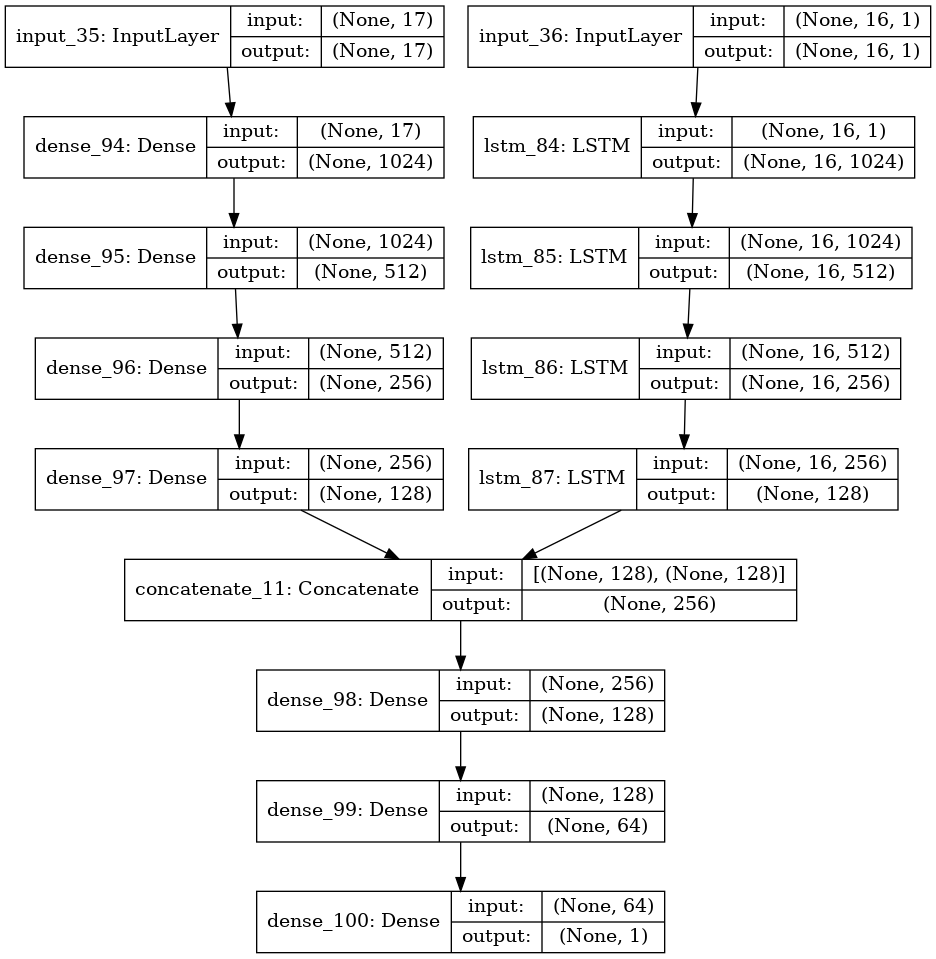

In [649]:
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot
plot_model(model, to_file='model_ensem4.png', show_shapes=True, show_layer_names=True, expand_nested=True)

## Ensem Summary

The best performing model had a QWK of 0.9854.  We can see that we get better scores when going wider and deeper. We choose to stop at this model since the training time is already getting too long.

The only problem is that SHAP is still not compatible with this architecture so we cannot explain the model.

# Discussion of Results

The summary of our results can be seen in Table 2 \ref{tab:model-accuracy}. The NNE had the highest QWK at 0.9854. This beats the winner of the Kaggle competition in 2012, the published SSWE BiLSTM (Alikaniotis et al, 2016),  and our human benchmark.

    Method & Test Accuracy & Training Time  \\
    NNE & 0.9854 & 33 mins \\
    GBR & 0.9848 & 6 mins \\
    Fully Connected Deep Network & 0.9774 & 2 mins \\
    Human Benchmark & 0.9693 & NA \\
    LSTM & 0.9658 & 17 mins \\
    SSWE BiLSTM (Alikaniotis et al, 2016) & 0.96 & NA \\
    Kaggle (2012) & 0.82 & NA \\



The results show that the NNE, GBR, and Fully Connected Deep Network were able to beat the human benchmark and other published state of the art models. 

The results show that we can achieve the best accuracy using the multi-input data approach. This is a more complex approach by using an ensemble of two different types of learners and then combining them into one. It shows that this neural network architecture is able to learn patterns better when the input data is more uniform. This method can be useful in any other text classification tasks because there are multiple data inputs that can be extracted from text data.

However, in terms of training time, the NNE took 33 minutes to train. The GBR method which had a QWK that was only 0.06 lower only needed 6 minutes to train. In terms of computational resources, the 0.06 QWK improvement is almost negligible considering the 550\% increase in training time. This is one big consideration that is required when choosing the model to be deployed.

In terms of model explicability and interpretability, the NNE model cannot be interpreted easily because of the lack of open-source libraries interpreting multi-input models. The GBR method again appears to be the better choice because of its easy feature importance explicability using SHAP. Using SHAP, we were able to see the most important features in the GBR model and the polarity of the relationship for each feature.


In the SHAP plot, we can see that the top 3 most important features are the essay set, the number of unique words or vocabulary size, and the number of sentences. The essay set importance agrees with our EDA that the feature is indeed significant. Not only does this show the significance of the feature but it also shows the effectiveness of the model to split the data using the essay set feature. It is evident that there are some essay sets with higher feature values that have a negative impact on the prediction. 

The summary plot shows that the extracted non-textual features ranked higher in terms of importance. We can see that a higher number of unique words resulted in higher scores. We also saw that a higher adjective count resulted in higher scores, which can show the vividness of the storytelling skill of the student.

Another important consideration for this study is AI ethics. The application of this model can have a large implication on education and society. Using the BNAJE framework, we can evaluate the Beneficence, Non-maleficence, Autonomy, Justice, and Explicability of the model (Floridi and Cowls, 2019). In its further development stage, it is important that the beneficence of the objective of the model is clear. Risk assessment should be done to ensure the non-maleficence of the model. Written consent must be given by the students before their essays are graded by the model. The model must be assessed to have no unintended bias and must be fair and just. And lastly, the model must be explicable with the use of feature importance plots and other similar methods.


# Conclusion

In this paper, we were able to develop an automated essay scoring (AES) model that gives a numerical score to unstructured text data. We did this by extracting syntactic and semantic features from the essay. We tested different machine learning algorithms to predict the score of the essays and evaluated the predictions using Quadratic Weighted Kappa (QWK). A balance between effectivity, efficiency, and explicability must be achieved, so we also evaluated the training time and explicability of the model.

Our best model, the Fully Connected Neural Network and LSTM Network Ensemble (NNE) obtained the highest QWK of 0.9854, beating the human benchmark and other published state of the art models. This demonstrates the power of using a multi-input data approach that allows the neural network to learn patterns in the data better.

In terms of computational efficiency and interpretability, we found that the GBR model was 5.5x faster to train and had better explicability by using SHAP. With the SHAP summary plot, we are able to see the impact of each feature from each sample to the trained model which makes the model interpretable and explicable to users and stakeholders.

We also discussed some AI ethics considerations that must be taken when designing and deploying the model into production. This can be done using the BNAJE framework in AI ethics.

Future improvements can be done on the model by using better document embedding techniques, training separate models for each essay set, extracting other features such as Latent Semantic Analysis (LSA) and sentiment scores. The non-textual features can also be normalized relative to the essay length and the essay scores from different essay sets can be normalized. Further research can be done on the explicability of the multi-input neural network architectures to improve the explicability of the NNE method.

# Acknowledgements

We would like to thank the William and Flora Hewlett Foundation (Hewlett) and Kaggle for the dataset that was used in this study. We wish to express our gratitude to our Natural Language Processing professor at the Asian Institute of Management, Madhavi Devaraj, PhD.


# References


\small Arora, Aman. (2019). Quadratic Kappa Metric explained in 5 simple steps. Retrieved from https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps

\small Barrus, Tyler. (2018). Pure Python Spell Checking. Retrieved from https://github.com/barrust/pyspellchecker

\small Bharath Ramsundar and Reza Bosagh Zadeh. 2018. TensorFlow for Deep Learning: From Linear Regression to Reinforcement Learning (1st. ed.). O’Reilly Media, Inc.

\small Bushaev, V. (2018, October 24). Adam-latest trends in deep learning optimization. Retrieved from https://towardsdatascience.com/adam-latest-trends-in-deep-learning- optimization- 6be9a291375c.

\small Chollet, François. (2015). Keras. Retrieved from https://github.com/fchollet/keras

\small Floridi, L., & Cowls, J. (2019). A Unified Framework of Five Principles for AI in Society. Harvard Data Science Review, 1(1). https://doi.org/10.1162/99608f92.8cd550d1

\small Friedman, J. (2001). Greedy boosting approximation: a gradient boosting machine. Ann. Stat. 29, 1189–1232. doi: 10.1214/aos/1013203451

\small Hastie, T., Tibshirani, R., Friedman, J. (2001). The Elements of Statistical Learning. New York, NY, USA: Springer New York Inc..

\small Jain, Aarshay. (2016). Complete Machine Learning Guide to Parameter Tuning in Gradient Boosting (GBM) in Python. Retrieved from https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

\small Karpathy, A. (2015). The Unreasonable Effectiveness of Recurrent Neural Networks

\small Le, Quoc & Mikolov, Tomas. (2014). Distributed representations of sentences and documents. In Proceedings of the 31st International Conference on International Conference on Machine Learning - Volume 32 (ICML’14). JMLR.org, II–1188–II–1196.

\small Lundberg, S.M., Erion, G., Chen, H. et al. From local explanations to global understanding with explainable AI for trees. Nat Mach Intell 2, 56–67 (2020). https://doi.org/10.1038/s42256-019-0138-9

\small Mikolov, Tomas & Joulin, Armand & Chopra, Sumit & Mathieu, Michael & Ranzato, Marc'Aurelio. (2014). Learning Longer Memory in Recurrent Neural Networks. 

\small Pedregosa et al. (2011). Scikit-learn: Machine Learning in Python. JMLR 12, pp. 2825-2830, 2011.

\small The Hewlett Foundation: Automated Essay Scoring. (2012). Retrieved from https://www.kaggle.com/c/asap-aes/

\small Řehůřek, Radim & Sojka, Petr. (2010). Software Framework for Topic Modelling with Large Corpora. 45-50. 10.13140/2.1.2393.1847. 

\small Shoaran, Mahsa & Haghi, Benyamin & Taghavi, Milad & Farivar, Masoud & Emami, Azita. (2018). Energy-Efficient Classification for Resource-Constrained Biomedical Applications. IEEE Journal on Emerging and Selected Topics in Circuits and Systems. PP. 1-1. 10.1109/JETCAS.2018.2844733.

\small Taghipour, Kaveh & Ng, Hwee. (2016). A Neural Approach to Automated Essay Scoring. 10.18653/v1/D16-1193.

\small TensorFlow Team. (2017). Introducing TensorFlow Feature Columns. Retrieved from https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html

\small Teichert, Gregory & Natarajan, A. & Ven, A. & Garikipati, Krishna. (2018). Machine learning materials physics: Integrable deep neural networks enable scale bridging by learning free energy functions.

\small Valkov, V. (2019, November 17). Demand Prediction with LSTMs using TensorFlow 2 and Keras in Python - Adventures in Artificial Intelligence: Venelin Valkov. Retrieved from https://www.curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/